In [ ]:
# Standard Library Imports
import os
import sys
from importlib import reload
from functools import partial
from enum import Enum
from typing import NamedTuple
from time import sleep

# Third-Party Library Imports
import numpy as np
from numpy.typing import ArrayLike
import pandas as pd
import xarray as xr
from scipy.stats import spearmanr

# Plotting imports
import hvplot.xarray
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker as mticker
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import seaborn as sns
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER



# My imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts'))
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts', 'src'))

import utils
import plotting_utils
import climate_utils
import stats
import time_of_emrgence_calc as toe
import toe_constants as toe_const
import open_data
from toe_constants import PVALUE_THESHOLD1, OVERLAP_THRESHOLD, SN_THRESHOLD1
import time_of_emergence_plots
import toe_constants as toe_const
import plotting_utils

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', message="p-value floored: true value smaller than 0.001")
warnings.filterwarnings('ignore', message="p-value capped: true value larger than 0.25")

Matplotlib created a temporary cache directory at /jobfs/117434597.gadi-pbs/matplotlib-655z74fe because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='numpy.lib.function_base')

In [ ]:
# import matplotlib.pylab as pylab
# pylab.rcParams.update({'axes.labelsize':20, 'xtick.labelsize': 16, 'ytick.labelsize': 16, 'figure.figsize': [12, 6]})

In [ ]:
from dask.distributed import Client
client = Client(threads_per_worker=1, n_workers=12)
client

In [ ]:
xr.set_options(display_expand_attrs=False)
xr.set_options(display_expand_data=True)
np.set_printoptions(precision=2, suppress=True, edgeitems=1)

In [6]:
data_ds = open_data.open_best()
# data_ds = open_data.open_gpcc()
# data_ds = data_ds.resample(time='QS-DEC').sum().compute()
# data_ds = data_ds.sel(time=data_ds.time.dt.month==12)

Opening best dataset from - /g/data/w40/ab2313/PhD/time_of_emergence/best/Land_and_Ocean_LatLong1_time_chunk.zarr
  -- overriding time to use cftime
  -- resampling to yearly mean


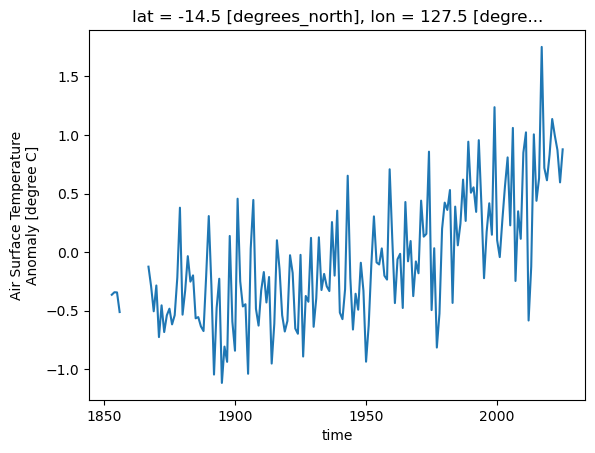

In [7]:
data_ds.sel(lat=-15, lon=127, method='nearest').plot()

In [8]:
# Create a data set for the base period used as the pre-industrial climate 
start_end_tuple = (1900, 1950)#(1900, 1931)
data_ds = data_ds.sel(time=data_ds.time.dt.year>=start_end_tuple[0])
data_ds

<xarray.DataArray 'temperature' (time: 125, lat: 180, lon: 360)> Size: 32MB
array([[[  nan, ...,   nan],
        ...,
        [ 0.22, ...,  0.22]],

       ...,

       [[-2.09, ..., -2.09],
        ...,
        [ 2.25, ...,  2.24]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1kB 1900-12-31 00:00:00 ... 2024-12-31 00:00:00
Attributes: (5)

Text(0.5, 1.0, 'Year 2000')

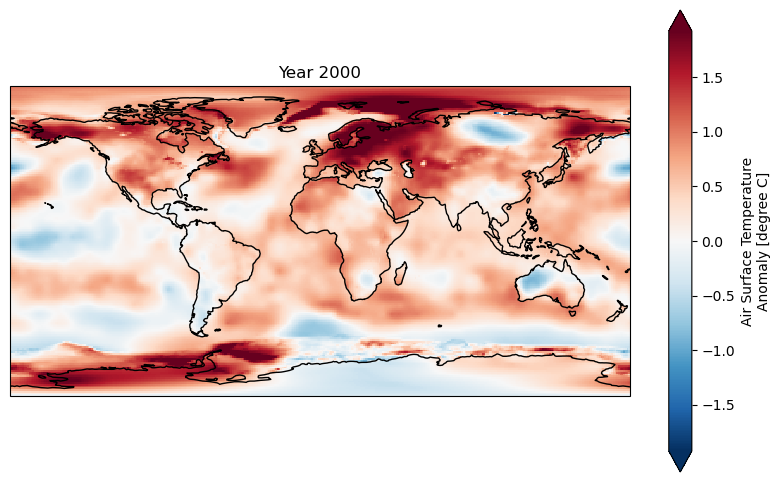

In [9]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
data_ds.isel(time=100).plot(ax=ax,robust=True)
ax.coastlines()
ax.set_title('Year 2000')

In [10]:
base_period_ds = data_ds.where(data_ds.time.dt.year.isin(np.arange(*start_end_tuple)), drop=True)
base_period_ds

<xarray.DataArray 'temperature' (time: 50, lat: 180, lon: 360)> Size: 13MB
array([[[  nan, ...,   nan],
        ...,
        [ 0.22, ...,  0.22]],

       ...,

       [[  nan, ...,   nan],
        ...,
        [-0.2 , ..., -0.2 ]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 400B 1900-12-31 00:00:00 ... 1949-12-31 00:00:00
Attributes: (5)

In [11]:
base_period_ds_count = base_period_ds.count(dim='time')

In [12]:
# Create a mask that removes any grid celss where there are less than 40 point in the base period
data_availability_mask = xr.where(base_period_ds_count>=40, 1, 0)
data_availability_mask

<xarray.DataArray 'temperature' (lat: 180, lon: 360)> Size: 518kB
array([[0, ..., 0],
       ...,
       [1, ..., 1]])
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

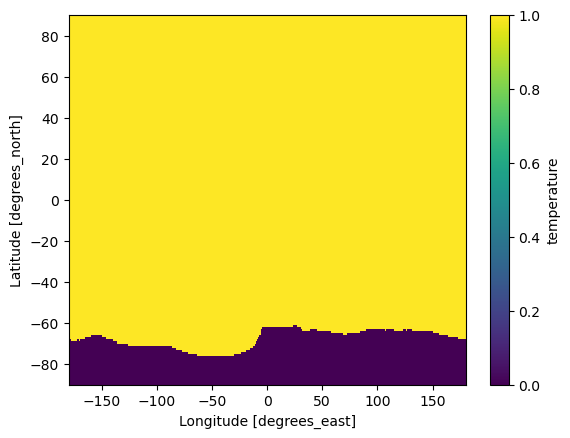

In [13]:
data_availability_mask.plot()

In [14]:
# Apply the mask to both the base period and the full dataset
data_ds = data_ds.where(data_availability_mask)
base_period_ds = base_period_ds.where(data_availability_mask)

In [15]:
# Resetting the anomlies to 1850
data_ds = data_ds - base_period_ds.mean(dim='time')
base_period_ds = base_period_ds - base_period_ds.mean(dim='time')

In [16]:
land_mask_ds = xr.open_dataarray('/g/data/w40/ab2313/PhD/time_of_emergence/best/best_mask.zarr')
land_mask_ds

<xarray.DataArray 'land_mask' (lat: 180, lon: 360)> Size: 518kB
[64800 values with dtype=float64]
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Attributes: (5)

# Part I: Method Comparison

## Dataset set-up

In [17]:
# P-value methods works better with a large cluster.
# Small chunks with large computation
client.cluster.scale(28)
sleep(7)

 -         Start Nanny at: 'tcp://127.0.0.1:45915'
 -         Start Nanny at: 'tcp://127.0.0.1:37119'
 -         Start Nanny at: 'tcp://127.0.0.1:36593'
 -         Start Nanny at: 'tcp://127.0.0.1:35017'
 -         Start Nanny at: 'tcp://127.0.0.1:46473'
 -         Start Nanny at: 'tcp://127.0.0.1:39595'
 -         Start Nanny at: 'tcp://127.0.0.1:38657'
 -         Start Nanny at: 'tcp://127.0.0.1:40491'
 -         Start Nanny at: 'tcp://127.0.0.1:41081'
 -         Start Nanny at: 'tcp://127.0.0.1:43945'
 -         Start Nanny at: 'tcp://127.0.0.1:43515'
 -         Start Nanny at: 'tcp://127.0.0.1:45845'
 -         Start Nanny at: 'tcp://127.0.0.1:45771'
 -         Start Nanny at: 'tcp://127.0.0.1:40097'
 -         Start Nanny at: 'tcp://127.0.0.1:44779'
 -         Start Nanny at: 'tcp://127.0.0.1:37713'


In [18]:
window = 20

In [19]:
CHUNKS_FOR_PVALUE_TESTS =  {'lat':30, 'lon':30, 'time':-1}

In [20]:
# Creting new datasets that has windown dimnsion for the rolling calculation
data_ds_window = (data_ds
                  .chunk(CHUNKS_FOR_PVALUE_TESTS)
                  .rolling(time=window, center=True, min_periods=window)
                  .construct('window_dim')
                  .persist()) 

base_period_window_ds = (base_period_ds
                         .chunk(CHUNKS_FOR_PVALUE_TESTS)
                         .rename({'time':'window_dim'})
                         .persist())

In [21]:
# The arguements needed for all of the calculations
rolling_window_kwargs = dict(
    input_core_dims=[['window_dim'], ['window_dim']],
    exclude_dims={'window_dim'},
    vectorize=True,
    dask='parallelized')

## OVerlap Methods

In [22]:
%%time
perkins_ds = xr.apply_ufunc(
    toe.perkins_skill_score,
    data_ds_window,
    base_period_window_ds,
    output_dtypes=float,
    **rolling_window_kwargs
    ).compute()

CPU times: user 18.9 s, sys: 3.27 s, total: 22.2 s
Wall time: 1min 19s


In [23]:
%%time
frac_geom_ds = xr.apply_ufunc(
    toe.farctional_geometric_area,
    data_ds_window,
    base_period_window_ds,
    output_dtypes=float,
    **rolling_window_kwargs
    ).compute()

CPU times: user 2min 1s, sys: 24.8 s, total: 2min 26s
Wall time: 11min 23s


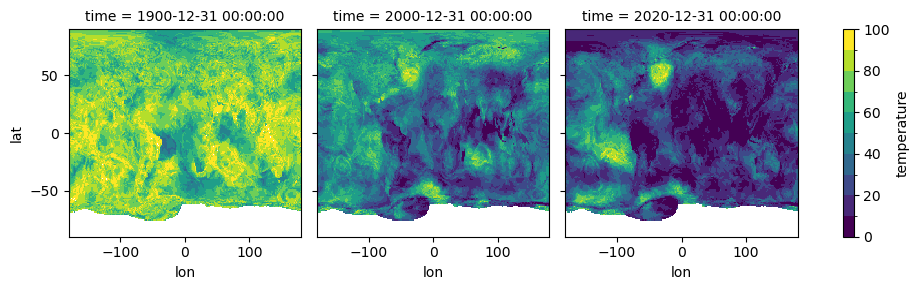

In [24]:
perkins_ds.isel(time=[0, 100, 120]).plot(col='time', levels=np.arange(0, 110, 10))

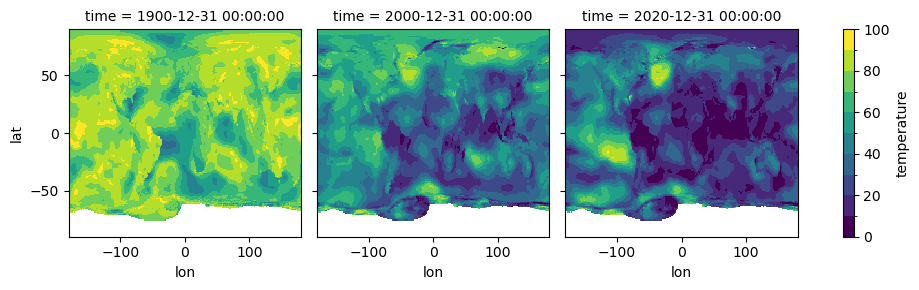

In [25]:
frac_geom_ds.isel(time=[0, 100, 120]).plot(col='time', levels=np.arange(0, 110, 10))

## P-value Methods

1d Array Method <br>

This method comapes starting from the begging and looops through. The nans are added to the end so the length matches

In [26]:
# The arguements needed for all of the calculations
rolling_window_kwargs = dict(
    input_core_dims=[['window_dim'], ['window_dim']],
    exclude_dims={'window_dim'},
    vectorize=True,
    dask='parallelized')

In [27]:
%%time
ttest_ds = xr.apply_ufunc(
        toe.return_ttest_pvalue,
        data_ds_window,
        base_period_window_ds,
    **rolling_window_kwargs
    ).compute()

CPU times: user 2min 10s, sys: 20.5 s, total: 2min 31s
Wall time: 9min 26s


In [28]:
%%time
ks_ds = xr.apply_ufunc(
        toe.return_ks_pvalue,
        data_ds_window,
        base_period_window_ds,
    **rolling_window_kwargs
    ).compute()

CPU times: user 54.8 s, sys: 8.21 s, total: 1min 3s
Wall time: 3min 34s


In [29]:
# ks_2samp will perfom on all nan slices
# ks_ds = ks_ds.where(data_ava`ilability_mask)

In [30]:
%%time
anderson_ds = xr.apply_ufunc(
    toe.return_anderson_pvalue,
    data_ds_window,
    base_period_window_ds,
    output_dtypes=float, 
    **rolling_window_kwargs
    ).compute()

/home/563/ab2313/Documents/time_of_emergene_drafts/src/time_of_emrgence_calc.py:40: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  pval = anderson_ksamp([test_arr, base_arr]).significance_level
/home/563/ab2313/Documents/time_of_emergene_drafts/src/time_of_emrgence_calc.py:40: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  pval = anderson_ksamp([test_arr, base_arr]).significance_level
/home/563/ab2313/Documents/time_of_emergene_drafts/src/time_of_emrgence_calc.py:40: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  pval = anderson_ksamp([test_arr, base_arr]).significance_level
/home/563/ab2313/Documents/time_of_emergene_drafts/src/time_of_emrgence_calc.py:40: UserWarning: p-value floored: true value smaller than 0.001. Consider 

CPU times: user 23.6 s, sys: 3.63 s, total: 27.2 s
Wall time: 1min 30s


### Verification that method works
Verifyting the abstracted (but faster) methods works by comparing to a single lat, lon point.

In [31]:
# This amount of workers is no longer need
client.cluster.scale(5)
sleep(7)

 - Closing Nanny at 'tcp://127.0.0.1:39227'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:35041'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:38013'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:39239'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:37821'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:36667'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:35957'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:45915'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:37119'. Reason: nan

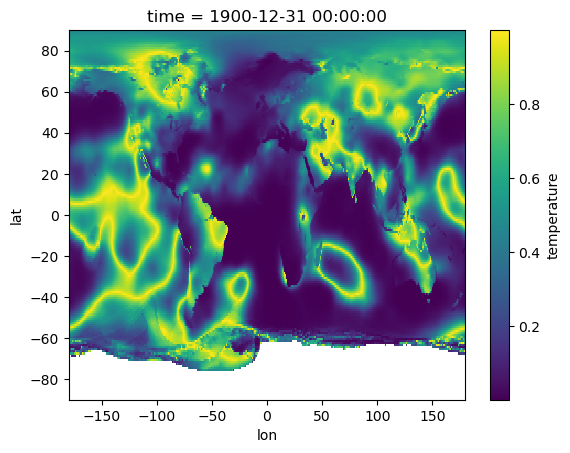

In [32]:
ttest_ds.isel(time=0).plot()

In [33]:
lat_lon_sp = dict(lat=-34, lon=145, method='nearest')

In [34]:
stats_test_1d_array_ttest = partial(
    toe.stats_test_1d_array, stats_func=toe.return_ttest_pvalue, window=window)

stats_test_1d_array_ks = partial(
    toe.stats_test_1d_array, stats_func=toe.return_ks_pvalue, window=window)

In [35]:
ttest_1d_1p = stats_test_1d_array_ttest(data_ds.sel(**lat_lon_sp))

In [36]:
ks_1d_1p = stats_test_1d_array_ks(data_ds.sel(**lat_lon_sp))

In [37]:
base_period_ds

<xarray.DataArray 'temperature' (time: 50, lat: 180, lon: 360)> Size: 13MB
array([[[  nan, ...,   nan],
        ...,
        [ 0.1 , ...,  0.1 ]],

       ...,

       [[  nan, ...,   nan],
        ...,
        [-0.32, ..., -0.32]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 400B 1900-12-31 00:00:00 ... 1949-12-31 00:00:00

In [38]:
data_ds

<xarray.DataArray 'temperature' (time: 125, lat: 180, lon: 360)> Size: 32MB
array([[[ nan, ...,  nan],
        ...,
        [0.1 , ..., 0.1 ]],

       ...,

       [[ nan, ...,  nan],
        ...,
        [2.13, ..., 2.12]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1kB 1900-12-31 00:00:00 ... 2024-12-31 00:00:00

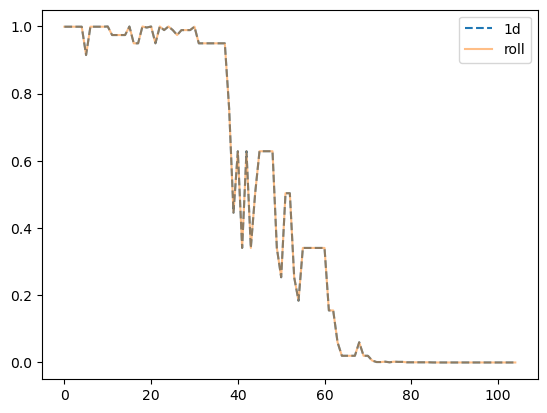

In [39]:
plt.plot(ks_1d_1p,label='1d', linestyle='--')
plt.plot(ks_ds.sel(**lat_lon_sp).isel(time=slice(int(window/2), -int(window/2))).values, label='roll', alpha=0.5)
plt.legend()

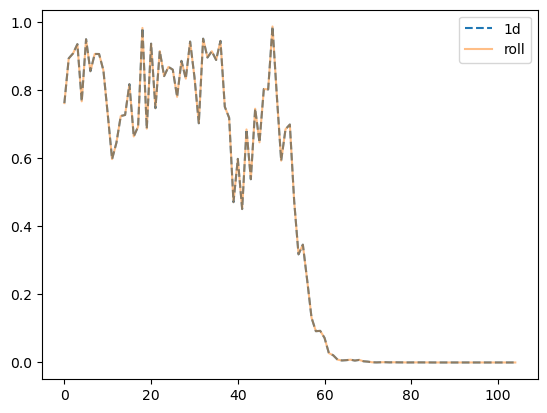

In [40]:
plt.plot(ttest_1d_1p,label='1d', linestyle='--')
plt.plot(ttest_ds.sel(**lat_lon_sp).isel(time=slice(int(window/2), -int(window/2))).values, label='roll', alpha=0.5)
plt.legend()

In [41]:
stats_test_1d_array_anderson = partial(
    toe.stats_test_1d_array, stats_func=toe.return_anderson_pvalue, window=window)

In [42]:
anderson_1d_1p = stats_test_1d_array_anderson(data_ds.sel(**lat_lon_sp))

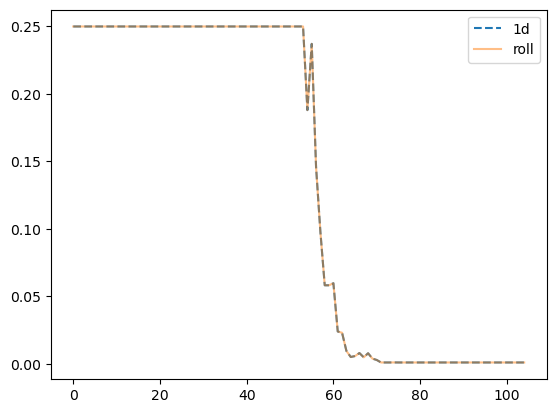

In [43]:
plt.plot(anderson_1d_1p, label='1d', linestyle='--')
plt.plot(anderson_ds.sel(**lat_lon_sp).isel(time=slice(int(window/2), -int(window/2))).values, label='roll', alpha=0.5)
plt.legend()

## Signal-to-Noise (hawkins)

In [44]:
# Calculate the wegithed mean
data_ds_smean = climate_utils.weighted_lat_lon_mean(data_ds)
data_ds_smean

<xarray.DataArray 'temperature' (time: 125)> Size: 500B
array([ 0.08,  0.  , -0.15, -0.26, -0.31, -0.13, -0.04, -0.2 , -0.24,
       -0.31, -0.27, -0.28, -0.2 , -0.18,  0.01,  0.07, -0.17, -0.31,
       -0.15, -0.1 , -0.03,  0.02, -0.06, -0.03, -0.04,  0.  ,  0.14,
        0.02,  0.04, -0.14,  0.08,  0.14,  0.09, -0.09,  0.05, -0.01,
        0.06,  0.22,  0.22,  0.21,  0.29,  0.24,  0.25,  0.31,  0.41,
        0.27,  0.12,  0.19,  0.09,  0.1 ,  0.02,  0.2 ,  0.28,  0.35,
        0.16,  0.07,  0.  ,  0.22,  0.26,  0.23,  0.2 ,  0.24,  0.22,
        0.24, -0.03,  0.09,  0.14,  0.16,  0.11,  0.25,  0.18,  0.06,
        0.17,  0.32,  0.09,  0.17,  0.1 ,  0.42,  0.29,  0.38,  0.45,
        0.53,  0.34,  0.51,  0.32,  0.34,  0.38,  0.52,  0.55,  0.46,
        0.64,  0.6 ,  0.41,  0.5 ,  0.54,  0.69,  0.55,  0.73,  0.88,
        0.64,  0.63,  0.77,  0.83,  0.84,  0.76,  0.9 ,  0.87,  0.85,
        0.75,  0.86,  0.97,  0.82,  0.88,  0.88,  0.96,  1.14,  1.25,
        1.15,  1.05,  1.19,  1.22,  1.09,  1.11,  1.42,  1.55],
      dtype=float32)
Coordinates:
  * time     (time) object 1kB 1900-12-31 00:00:00 ... 2024-12-31 00:00:00

In [45]:
# Get lowess filtered version
data_ds_smean_lowess = stats.trend_fit(data_ds_smean, method='LOWESS', lowess_window=41)

In [46]:
%%time
return_hawkins_signal_and_noise_partial = partial(toe.return_hawkins_signal_and_noise, gt=data_ds_smean_lowess.values)

ds_data_signal, ds_data_noise_series = xr.apply_ufunc(
    return_hawkins_signal_and_noise_partial,
    data_ds,
    input_core_dims=[['time']], 
    output_core_dims=[['time'], ['time']], 
    dask='parallelized', 
    vectorize=True,
    output_dtypes=[float, float],
)

CPU times: user 8.18 s, sys: 1.45 s, total: 9.63 s
Wall time: 7.69 s


In [47]:
# Noise 
ds_data_noise = ds_data_noise_series.std(dim='time').compute()
# Compute signal
ds_data_signal = ds_data_signal.compute()
# S/N Ratio 
ds_data_sn = ds_data_signal/ds_data_noise

In [48]:
client.cluster.scale(18)
sleep(7)

 -         Start Nanny at: 'tcp://127.0.0.1:43081'
 -         Start Nanny at: 'tcp://127.0.0.1:39811'
 -         Start Nanny at: 'tcp://127.0.0.1:37707'
 -         Start Nanny at: 'tcp://127.0.0.1:35847'
 -         Start Nanny at: 'tcp://127.0.0.1:42335'
 -         Start Nanny at: 'tcp://127.0.0.1:43441'
 -         Start Nanny at: 'tcp://127.0.0.1:36533'
 -         Start Nanny at: 'tcp://127.0.0.1:33301'
 -         Start Nanny at: 'tcp://127.0.0.1:43507'
 -         Start Nanny at: 'tcp://127.0.0.1:36515'
 -         Start Nanny at: 'tcp://127.0.0.1:42539'
 -         Start Nanny at: 'tcp://127.0.0.1:40835'
 -         Start Nanny at: 'tcp://127.0.0.1:35179'
 - Event loop was unresponsive in Nanny for 3.69s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 3.54s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can c

In [49]:
ds_data_signal_lowess = xr.apply_ufunc(
    stats.apply_lowess, 
    data_ds.chunk({'time':-1, 'lat':10}), 
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True, 
    dask='parallelized',    
).compute()


In [50]:
# Noise series is detrended data
ds_data_noise_series_lowess = data_ds - ds_data_signal_lowess
# Noise is std of detrended data
ds_data_noise_lowess = ds_data_noise_series_lowess.std(dim='time').compute()
# S/N Ratio
ds_data_sn_lowess = ds_data_signal_lowess/ds_data_noise_lowess

In [51]:
ds_data_sn_lowess

<xarray.DataArray 'temperature' (lat: 180, lon: 360, time: 125)> Size: 65MB
array([[[  nan, ...,   nan],
        ...,
        [  nan, ...,   nan]],

       ...,

       [[-0.54, ...,  3.01],
        ...,
        [-0.54, ...,  3.01]]])
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1kB 1900-12-31 00:00:00 ... 2024-12-31 00:00:00

In [52]:
client.cluster.scale(6)
sleep(7)

 - Closing Nanny at 'tcp://127.0.0.1:43081'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:39811'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:37707'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:35847'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:42335'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:43441'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:36533'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:33301'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:36515'. Reason: nan

### Verification Plots

In [53]:
sel_dict = dict(lat=-38, lon=144, method='nearest')

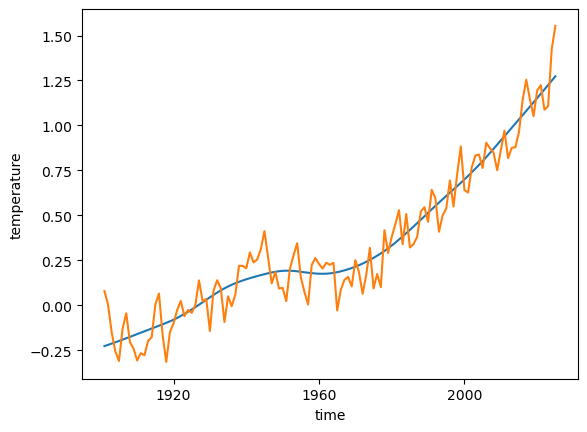

In [54]:
data_ds_smean_lowess.plot()
data_ds_smean.plot()

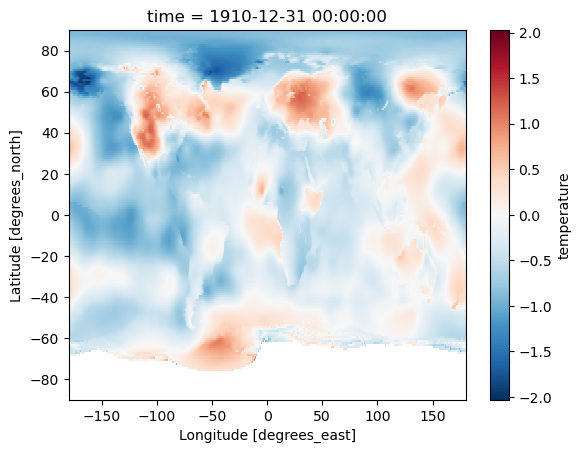

In [55]:
data_ds.isel(time=10).plot()

In [56]:
# Veriftying for a single point
signal_sp, noise_series_sp, reocnstructed_sp =\
    return_hawkins_signal_and_noise_partial(
        data_ds.sel(**sel_dict).values, return_reconstruction=True)

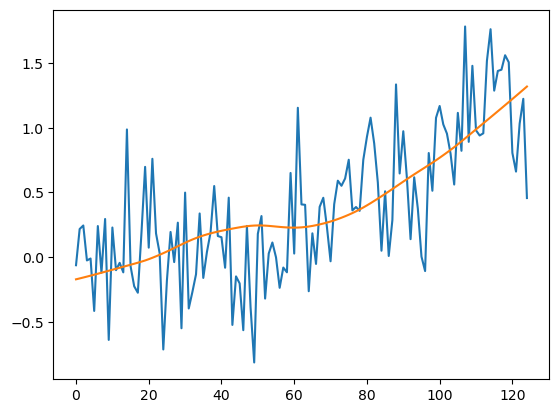

In [57]:
# Thhe reconstruced should thread the original data.
# The reconstructed int the scaled version of the global
plt.plot(data_ds.sel(**sel_dict).values)
plt.plot(reocnstructed_sp)

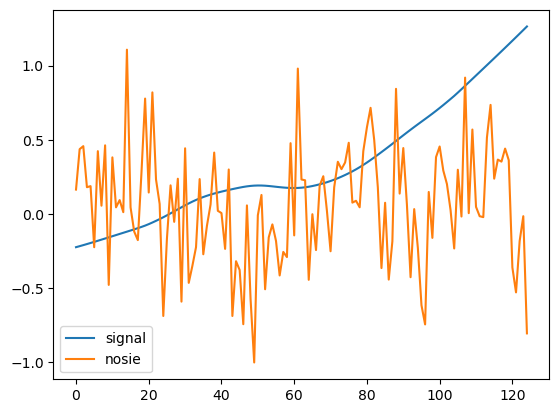

In [58]:
plt.plot(signal_sp, label='signal')
plt.plot(noise_series_sp, label='nosie')
plt.legend()

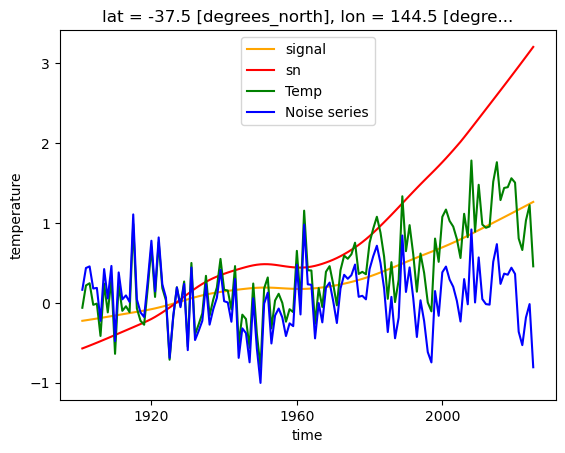

In [59]:
fig, ax1 = plt.subplots(1, 1)
ax2 = ax1#.twinx()
ds_data_signal.sel(**sel_dict).plot(ax=ax1, label='signal', color='orange')
ds_data_sn.sel(**sel_dict).plot(ax=ax1, label='sn', color='red')

data_ds.sel(**sel_dict).plot(ax=ax2, label='Temp', color='green')
ds_data_noise_series.sel(**sel_dict).plot(ax=ax2, color='blue', label='Noise series')

ax1.legend()
ax2.legend(loc='upper center')

Text(0.5, 1.0, 'LOWESS VERSION')

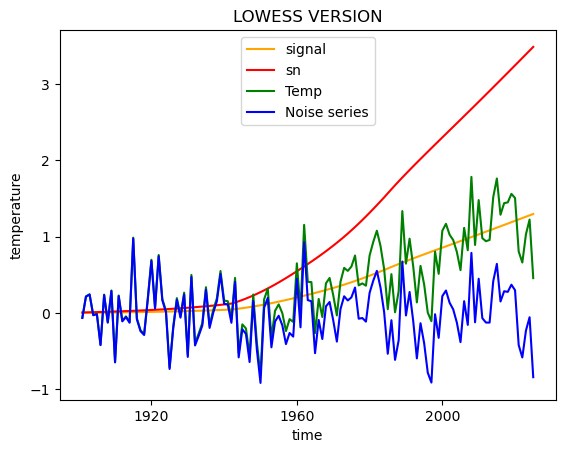

In [60]:
fig, ax1 = plt.subplots(1, 1)
ax2 = ax1#.twinx()
ds_data_signal_lowess.sel(**sel_dict).plot(ax=ax1, label='signal', color='orange')
ds_data_sn_lowess.sel(**sel_dict).plot(ax=ax1, label='sn', color='red')

data_ds.sel(**sel_dict).plot(ax=ax2, label='Temp', color='green')
ds_data_noise_series_lowess.sel(**sel_dict).plot(ax=ax2, color='blue', label='Noise series')

ax1.legend()
ax2.legend(loc='upper center')

ax1.set_title('LOWESS VERSION')

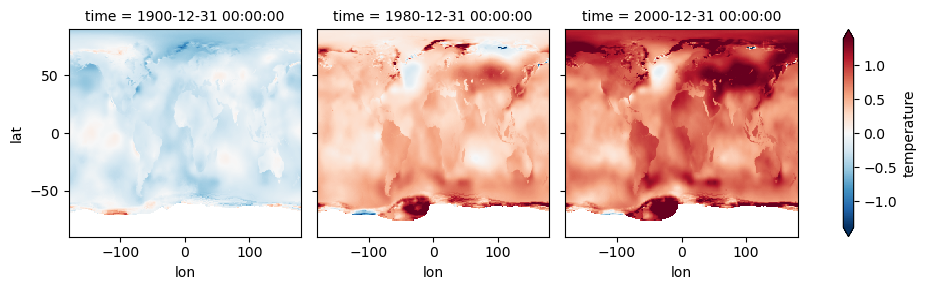

In [61]:
ds_data_signal_lowess.isel(time=[0, 80, 100]).plot(col='time', robust=True)

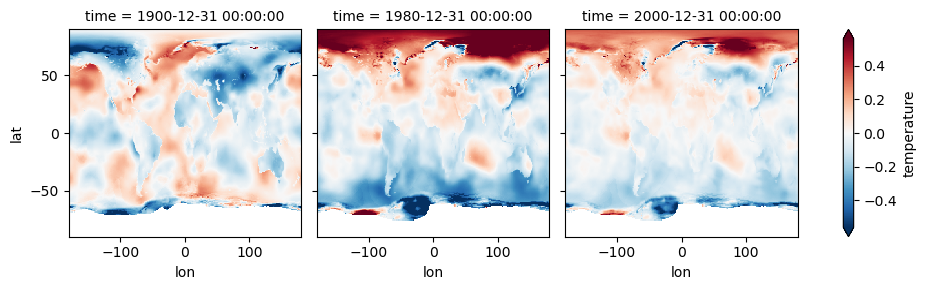

In [62]:
(ds_data_signal.isel(time=[0, 80, 100])-ds_data_signal_lowess.isel(time=[0, 80, 100])).plot(col='time', robust=True)

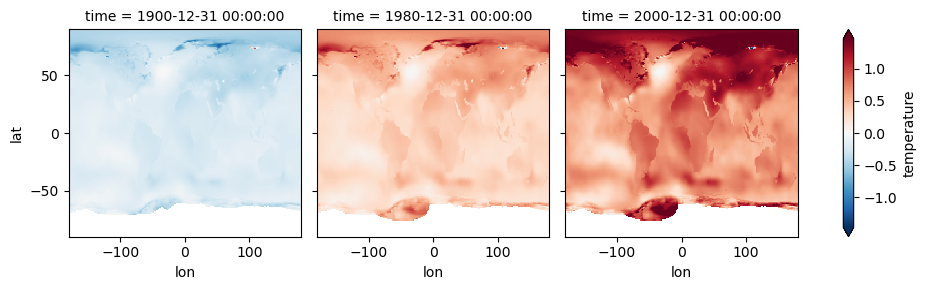

In [63]:
ds_data_signal.isel(time=[0, 80, 100]).plot(col='time', robust=True)

In [64]:
ds_data_sn.isel(time=-1).hvplot(robust=True, cmap='RdBu')

:Image   [lon,lat]   (temperature)

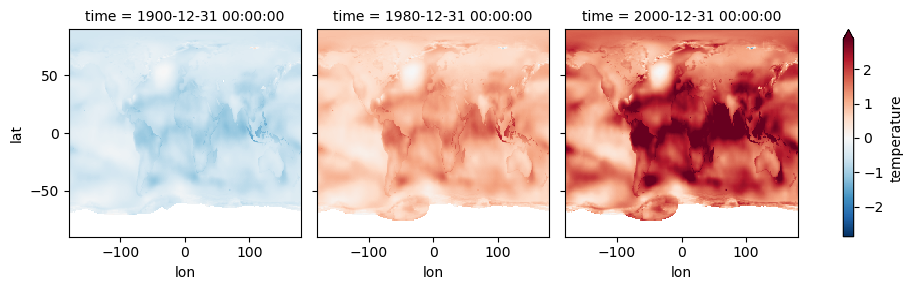

In [65]:
ds_data_sn.isel(time=[0, 80, 100]).plot(col='time', robust=True)

## Emergence Calculation

In [66]:
ds_data_sn.name = 'signal_to_noise'
ds_data_sn_lowess.name = 'signal_to_noise'

ttest_ds.name = 'ttest'
ks_ds.name = 'ks'
anderson_ds.name = 'anderson'
perkins_ds.name = 'perkins'
frac_geom_ds.name = 'frac'

In [67]:
# Set long name attributes for each variable
ds_data_sn.attrs['long_name'] = 'Signal-to-Noise Ratio'
ds_data_sn_lowess.attrs['long_name'] = 'Signal-to-Noise Ratio'

ks_ds.attrs['long_name'] = 'Kolmogorov-Smirnov'
ttest_ds.attrs['long_name'] = 'T-Test'
anderson_ds.attrs['long_name'] = 'Anderson-Darling'
perkins_ds.attrs['long_name'] = 'Perkins Skill Score'
frac_geom_ds.attrs['long_name'] = 'Fractional Geometric Area'

In [68]:
toe_metrics_ds = xr.merge([ks_ds, ttest_ds, anderson_ds, ds_data_sn, perkins_ds, frac_geom_ds])
toe_metrics_ds = toe_metrics_ds.isel(time=slice(int(window/2), -int(window/2)))
toe_metrics_ds = toe_metrics_ds.compute()
toe_metrics_ds

<xarray.Dataset> Size: 327MB
Dimensions:          (lat: 180, lon: 360, time: 105)
Coordinates:
  * lat              (lat) float32 720B -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon              (lon) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * time             (time) object 840B 1910-12-31 00:00:00 ... 2014-12-31 00...
Data variables:
    ks               (time, lat, lon) float64 54MB nan nan ... 1.82e-11 1.82e-11
    ttest            (time, lat, lon) float64 54MB nan nan ... 3.238e-15
    anderson         (time, lat, lon) float64 54MB nan nan nan ... 0.001 0.001
    signal_to_noise  (lat, lon, time) float64 54MB nan nan nan ... 2.287 2.34
    perkins          (time, lat, lon) float64 54MB nan nan nan ... 16.0 16.0
    frac             (time, lat, lon) float64 54MB nan nan nan ... 21.12 21.11
Attributes: (1)

In [69]:
# Finding when each test does not emerge
sn_does_not_emerge = (toe_metrics_ds['signal_to_noise'].isel(time=-1) <= 1)
ks_does_not_emerge = (toe_metrics_ds['ks'].isel(time=-1) >= PVALUE_THESHOLD1)
ttest_does_not_emerge = (toe_metrics_ds['ttest'].isel(time=-1) >= PVALUE_THESHOLD1)
anderson_does_not_emerge = (toe_metrics_ds['anderson'].isel(time=-1) >= PVALUE_THESHOLD1)

perkins_does_not_emerge = (toe_metrics_ds['perkins'].isel(time=-1) >= OVERLAP_THRESHOLD)
frac_geom_ds_does_not_emerge = (toe_metrics_ds['frac'].isel(time=-1) >= OVERLAP_THRESHOLD)

does_not_emerge_ds = xr.merge([sn_does_not_emerge, ks_does_not_emerge,ttest_does_not_emerge , anderson_does_not_emerge,
                              perkins_does_not_emerge,frac_geom_ds_does_not_emerge])

In [70]:
sn_toe_t1_ds = toe.get_permanent_exceedance(np.abs(toe_metrics_ds['signal_to_noise']), threshold=1, comparison_func=np.greater_equal).expand_dims(threshold=[1])
sn_toe_t2_ds = toe.get_permanent_exceedance(np.abs(toe_metrics_ds['signal_to_noise']), threshold=2, comparison_func=np.greater_equal).expand_dims(threshold=[2])
sn_toe_t3_ds = toe.get_permanent_exceedance(np.abs(toe_metrics_ds['signal_to_noise']), threshold=3, comparison_func=np.greater_equal).expand_dims(threshold=[3])
sn_toe_t4_ds = toe.get_permanent_exceedance(np.abs(toe_metrics_ds['signal_to_noise']), threshold=4, comparison_func=np.greater_equal).expand_dims(threshold=[4])

In [71]:
sn_does_not_emerge_t1 = (np.abs(toe_metrics_ds['signal_to_noise'].isel(time=-1)) <= 1).expand_dims(threshold=[1])
sn_does_not_emerge_t2 = (np.abs(toe_metrics_ds['signal_to_noise'].isel(time=-1)) <= 2).expand_dims(threshold=[2])
sn_does_not_emerge_t3 = (np.abs(toe_metrics_ds['signal_to_noise'].isel(time=-1)) <= 3).expand_dims(threshold=[3])
sn_does_not_emerge_t4 = (np.abs(toe_metrics_ds['signal_to_noise'].isel(time=-1)) <= 4).expand_dims(threshold=[4])

In [72]:
toe_sn_multi_thresh_ds = xr.concat([sn_toe_t1_ds, sn_toe_t2_ds, sn_toe_t3_ds, sn_toe_t4_ds], dim='threshold')
toe_sn_multi_thresh_ds

<xarray.DataArray 'signal_to_noise' (threshold: 4, lat: 180, lon: 360)> Size: 2MB
array([[[  nan, ...,   nan],
        ...,
        [1986., ..., 1986.]],

       ...,

       [[  nan, ...,   nan],
        ...,
        [  nan, ...,   nan]]])
Coordinates:
  * threshold  (threshold) int64 32B 1 2 3 4
  * lat        (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon        (lon) float32 1kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Attributes: (1)

In [73]:
sn_does_not_emerge_multi_thresh_ds = xr.concat([sn_does_not_emerge_t1, sn_does_not_emerge_t2, sn_does_not_emerge_t3, 
                                                sn_does_not_emerge_t4], dim='threshold')

In [74]:
# # The distribution overlap methods
perkins_toe_ds = toe.get_permanent_exceedance(perkins_ds, threshold=OVERLAP_THRESHOLD, comparison_func=np.less_equal)
frac_geom_toe_ds = toe.get_permanent_exceedance(frac_geom_ds, threshold=OVERLAP_THRESHOLD, comparison_func=np.less_equal)

In [75]:
# Find the year of permanent exceedance
sn_toe_ds = toe.get_permanent_exceedance(np.abs(toe_metrics_ds['signal_to_noise']), threshold=1, comparison_func=np.greater_equal)
ks_toe_ds = toe.get_permanent_exceedance(toe_metrics_ds['ks'], threshold=PVALUE_THESHOLD1, comparison_func=np.less)
ttest_toe_ds = toe.get_permanent_exceedance(toe_metrics_ds['ttest'], threshold=PVALUE_THESHOLD1, comparison_func=np.less)
anderson_toe_ds = toe.get_permanent_exceedance(toe_metrics_ds['anderson'], threshold=PVALUE_THESHOLD1, comparison_func=np.less)

toe_ds = xr.merge([sn_toe_ds, ks_toe_ds,ttest_toe_ds , anderson_toe_ds, perkins_toe_ds, frac_geom_toe_ds])
# If have emerged too late, it has not emerged
toe_ds = xr.where(toe_ds<2015, toe_ds, np.nan)


In [76]:
does_not_emerge_ds = xr.where(np.isnan(toe_ds),1, does_not_emerge_ds)
does_not_emerge_ds = xr.where(data_availability_mask, does_not_emerge_ds, np.nan)

In [77]:
# Make same order 
toe_metrics_ds = toe_metrics_ds[list(toe_ds.data_vars)]
toe_metrics_ds

<xarray.Dataset> Size: 327MB
Dimensions:          (lat: 180, lon: 360, time: 105)
Coordinates:
  * lat              (lat) float32 720B -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon              (lon) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * time             (time) object 840B 1910-12-31 00:00:00 ... 2014-12-31 00...
Data variables:
    signal_to_noise  (lat, lon, time) float64 54MB nan nan nan ... 2.287 2.34
    ks               (time, lat, lon) float64 54MB nan nan ... 1.82e-11 1.82e-11
    ttest            (time, lat, lon) float64 54MB nan nan ... 3.238e-15
    anderson         (time, lat, lon) float64 54MB nan nan nan ... 0.001 0.001
    perkins          (time, lat, lon) float64 54MB nan nan nan ... 16.0 16.0
    frac             (time, lat, lon) float64 54MB nan nan nan ... 21.12 21.11
Attributes: (1)

In [78]:
difference_sn_ks_ds = toe_ds['signal_to_noise'] - toe_ds['ks']

In [79]:
# Calculate an array of lat,lon, time, where there are 1s after emergenace has occured
# and zeros before emergence
# calculate_returned_binary_ds = partial(toe.calculate_returned_binary_ds, time_years=toe_metrics_ds.time.dt.year.values)

binary_emergence_ds = xr.apply_ufunc(
    toe.calculate_returned_binary_ds,
    toe_metrics_ds,
    toe_ds,
    toe_metrics_ds.time.dt.year.values,
    input_core_dims = [['time'], [], ['time']],
    output_core_dims=[['time']],
    vectorize=True,
    dask='parallelized'
)

In [80]:
# TODO: Somehow, non-zero and one values get in here. This will fix
# but should not be a long-term soluation
binary_emergence_ds = xr.where(binary_emergence_ds == 1, 1, 0)
binary_emergence_ds = binary_emergence_ds.where(data_availability_mask)

In [81]:
# Calculate the percent of points stable for different reiogns
emergence_time_series_ds = toe.calculate_percent_stable_for_regions(binary_emergence_ds, land_mask_ds,
                                                                   only_1s_ds = data_availability_mask, logginglevel='ERROR')

emergence_time_series_ds

<xarray.Dataset> Size: 51kB
Dimensions:          (region: 10, time: 105)
Coordinates:
  * region           (region) object 80B 'global' 'land' ... 'antarctic'
  * time             (time) object 840B 1910-12-31 00:00:00 ... 2014-12-31 00...
Data variables:
    signal_to_noise  (region, time) float64 8kB 0.0 0.0 0.0 ... 81.26 82.06 82.4
    ks               (region, time) float64 8kB 0.0 0.0 0.0 ... 88.34 89.45
    ttest            (region, time) float64 8kB 0.0 0.0 0.0 ... 88.89 89.23
    anderson         (region, time) float64 8kB 0.0 0.0 0.0 ... 83.02 83.89
    perkins          (region, time) float64 8kB 0.0 0.0 0.0 ... 85.05 85.05
    frac             (region, time) float64 8kB 0.0 0.0 0.0 ... 81.12 81.34
Attributes: (10)

In [82]:
# Get the signal-to-noise value at the year that the KS test emerged
find_value_at_emergence_arg_partial = partial(toe.find_value_at_emergence_arg,
                                              time_years=toe_metrics_ds.time.dt.year.values)

In [83]:
sn_at_ks_emergence_ds = xr.apply_ufunc(
    find_value_at_emergence_arg_partial,
    toe_metrics_ds['signal_to_noise'], # Time series
    toe_ds['ks'], # Year of emergence
    input_core_dims = [['time'], []],
    output_core_dims=[[]],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float]
)

In [84]:
sn_at_overlap_emergence_ds = xr.apply_ufunc(
    find_value_at_emergence_arg_partial,
    toe_metrics_ds['signal_to_noise'], # Time series
    toe_ds['frac'], # Year of emergence
    input_core_dims = [['time'], []],
    output_core_dims=[[]],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float]
)

In [85]:
overlap_at_ks_emergence_ds = xr.apply_ufunc(
    find_value_at_emergence_arg_partial,
    toe_metrics_ds['frac'], # Time series
    toe_ds['ks'], # Year of emergence
    input_core_dims = [['time'], []],
    output_core_dims=[[]],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float]  
)

In [86]:
overlap_at_sn_emergence_ds = xr.apply_ufunc(
    find_value_at_emergence_arg_partial,
    toe_metrics_ds['frac'], # Time series
    toe_ds['signal_to_noise'], # Year of emergence
    input_core_dims = [['time'], []],
    output_core_dims=[[]],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float]    
)

In [87]:
overlap_at_ks_emergence_ds.name = 'overlap_at_ks'
overlap_at_sn_emergence_ds.name =  'overlap_at_sn'
sn_at_ks_emergence_ds.name =  'sn_at_ks'
sn_at_overlap_emergence_ds.name =  'sn_at_overlap'

overlap_at_ks_emergence_ds.attrs['long_name'] = 'Overlap at KS Emergence'
overlap_at_sn_emergence_ds.attrs['long_name'] = 'Overlap at S/N Ratio Emergence'
sn_at_ks_emergence_ds.attrs['long_name'] = 'S/N Ratio at KS Emergence'
sn_at_overlap_emergence_ds.attrs['long_name'] = 'S/N Ratio at Overlap Emergence'

(array([   11.,   116.,   564.,  1953., 12658., 36706.,   164.,    83.,
           42.,     3.]),
 array([-67. , -54.5, -42. , -29.5, -17. ,  -4.5,   8. ,  20.5,  33. ,
         45.5,  58. ]),
 <BarContainer object of 10 artists>)

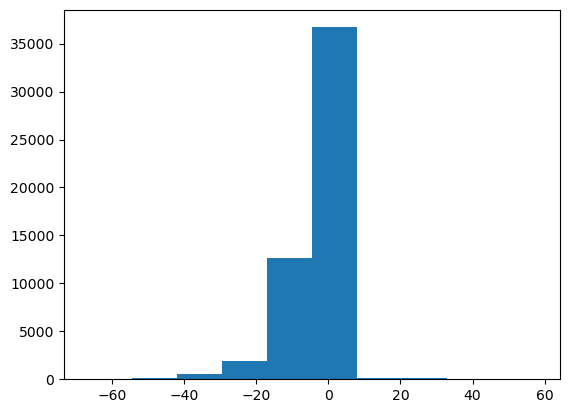

In [88]:
(toe_ds['ks'] - toe_ds['frac']).plot.hist()

In [89]:
overlap_at_sn_emergence_ds.median()

<xarray.DataArray 'overlap_at_sn' ()> Size: 8B
array(64.93)

(array([    1.,     2.,     9.,   125.,   311.,  1792., 15682., 29333.,
         7111.,   356.]),
 array([27.36, 32.54, 37.73, 42.92, 48.1 , 53.29, 58.48, 63.67, 68.85,
        74.04, 79.23]),
 <BarContainer object of 10 artists>)

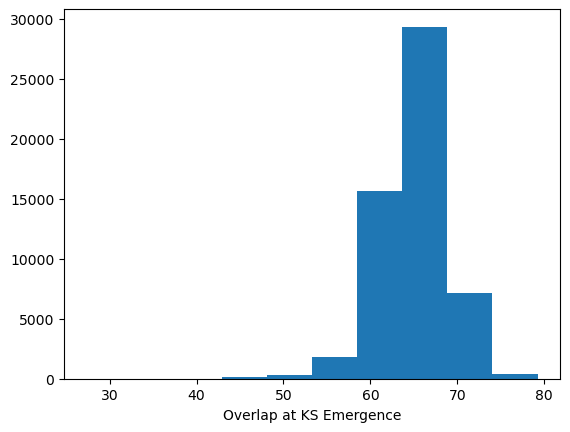

In [90]:
overlap_at_ks_emergence_ds.plot.hist()

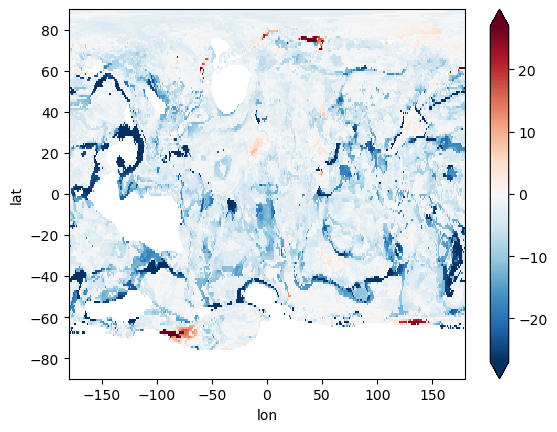

In [91]:
(toe_ds['ks'] - toe_ds['frac']).plot(robust=True)

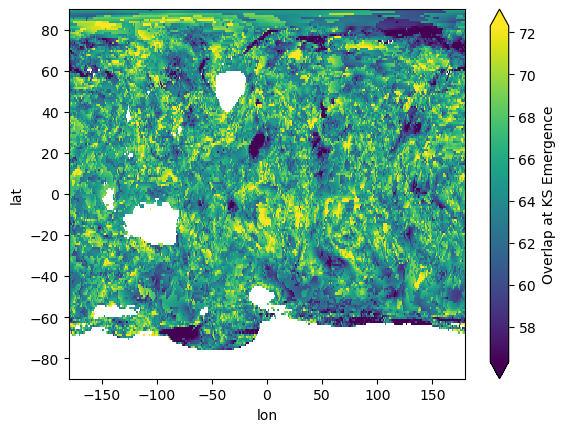

In [92]:
overlap_at_ks_emergence_ds.plot(robust=True)

## Plotting

In [93]:
# Create a custom colormap with two colors: gray and transparent
colors = [(0, 0, 0, 0), (0.5, 0.5, 0.5, 1)]  # (R, G, B, Alpha)
cmap_binary = mcolors.LinearSegmentedColormap.from_list("binary_no_color", colors)

In [94]:
def hatch(ax, ds, **kwargs):
    LON, LAT = np.meshgrid(ds.lon.values, ds.lat.values)
    ax.contourf(LON, LAT, ds.values, levels=[-1, 0, 1, 2], **kwargs)

In [119]:
not_stable_kwargs = dict(add_colorbar=False, hatches=['', '////'], alpha=0, colors=None)

not_stable_kwargs2 = dict(cmap=cmap_binary, add_colorbar=False)

In [120]:
data_unavailability_mask = xr.where(data_availability_mask, False, True)

### Correlations

In [101]:
ds_data_signal

<xarray.DataArray 'temperature' (lat: 180, lon: 360, time: 125)> Size: 65MB
array([[[  nan, ...,   nan],
        ...,
        [  nan, ...,   nan]],

       ...,

       [[-0.44, ...,  2.48],
        ...,
        [-0.44, ...,  2.48]]])
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1kB 1900-12-31 00:00:00 ... 2024-12-31 00:00:00

In [97]:
data_ds

<xarray.DataArray 'temperature' (time: 125, lat: 180, lon: 360)> Size: 32MB
array([[[ nan, ...,  nan],
        ...,
        [0.1 , ..., 0.1 ]],

       ...,

       [[ nan, ...,  nan],
        ...,
        [2.13, ..., 2.12]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1kB 1900-12-31 00:00:00 ... 2024-12-31 00:00:00

In [106]:
signal_data_corr_ds = xr.corr(ds_data_signal, data_ds, dim='time') 

In [122]:
signal_version_corr_ds = xr.corr(ds_data_signal, ds_data_signal_lowess, dim='time') 

In [133]:
bad_sn_version_corr = signal_version_corr_ds.where(signal_version_corr_ds < 0.9, np.nan)#.plot()

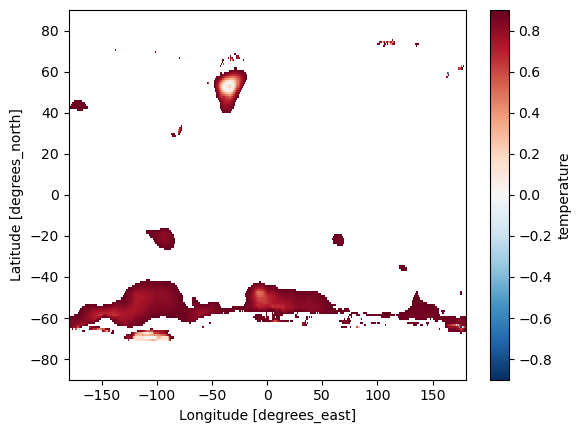

In [134]:
bad_sn_version_corr.plot()

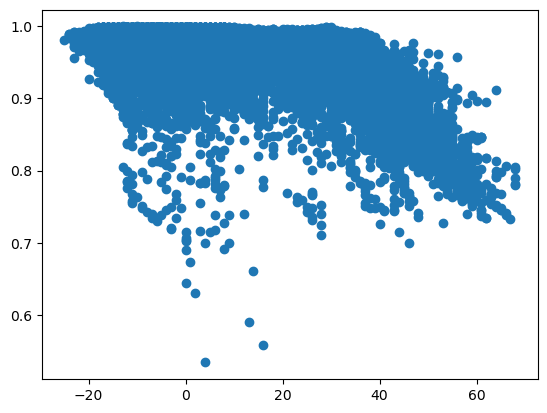

In [139]:
plt.scatter(difference_sn_ks_ds.values.flatten(),
          signal_version_corr_ds.values.flatten() )

(array([0.  , 0.03, 0.03, 0.02, 0.01, 0.01, 0.01, 0.  , 0.  , 0.  ]),
 array([-25. , -15.7,  -6.4,   2.9,  12.2,  21.5,  30.8,  40.1,  49.4,
         58.7,  68. ]),
 <BarContainer object of 10 artists>)

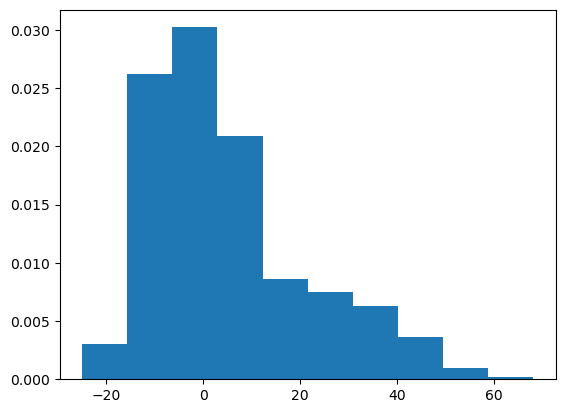

In [146]:
plt.hist(difference_sn_ks_ds.values.flatten(), density=True)

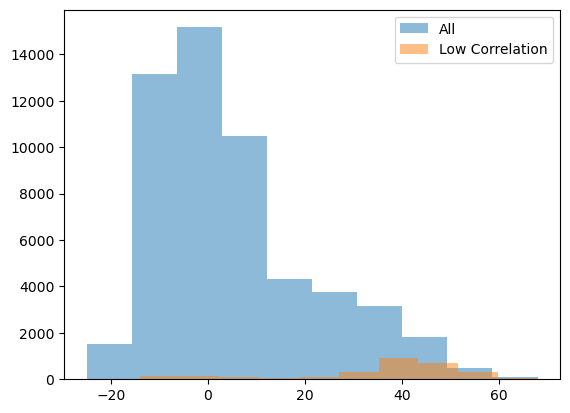

In [149]:
plt.hist(difference_sn_ks_ds.values.flatten(), label='All', alpha=0.5)
plt.hist(difference_sn_ks_ds.where(np.isfinite(bad_sn_version_corr)).values.flatten(), 
         label='Low Correlation', alpha=0.5)
plt.legend()

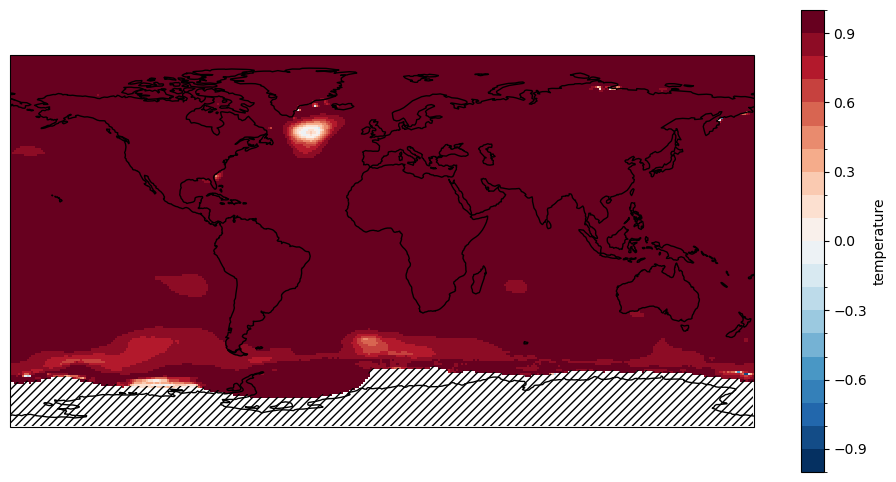

In [124]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
signal_version_corr_ds.plot(ax=ax, levels=np.arange(-1, 1.1, 0.1))
ax.coastlines()
hatch(ax, data_unavailability_mask, **not_stable_kwargs)

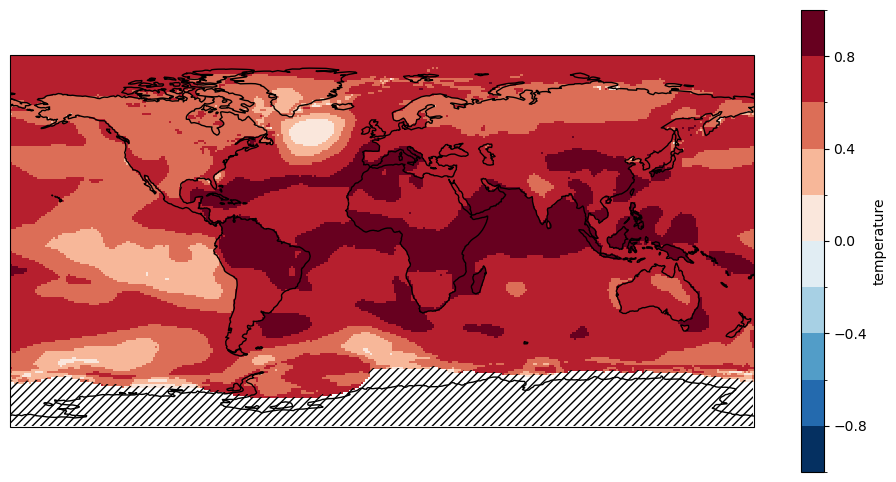

In [121]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
signal_data_corr_ds.plot(ax=ax, levels=np.arange(-1, 1.2, 0.2))
ax.coastlines()
hatch(ax, data_unavailability_mask, **not_stable_kwargs)

In [107]:
corr_flat = signal_data_corr_ds.values.flatten()
difference_sn_ks_flat = difference_sn_ks_ds.values.flatten()

In [108]:
print(signal_data_corr_ds.stack(latlon=['lat', 'lon']).drop('lat'))

<xarray.DataArray 'temperature' (latlon: 64800)> Size: 518kB
array([ nan, ..., 0.67])
Dimensions without coordinates: latlon


In [109]:
# This is a better way of getting all the smallest and largest locations of correlations
signal_data_corr_ds_stacked = signal_data_corr_ds.stack(latlon=['lat', 'lon'])
signal_data_corr_ds_stacked = signal_data_corr_ds_stacked.dropna(dim='latlon')
signal_data_corr_ds_stacked.name = 'correlation'

correlation_df = signal_data_corr_ds_stacked.to_dataframe(name='correlation')#.reset_index()
correlation_df = pd.DataFrame({'latlon':list(zip(correlation_df['lat'].values, correlation_df['lon'].values)), 
                               'correlation': correlation_df['correlation'].values}).set_index('latlon')
correlation_df = correlation_df.sort_values('correlation')
correlation_df.head()

correlation
latlon                    
(51.5, -31.5)     0.001173
(51.5, -35.5)     0.001539
(53.5, -36.5)     0.001798
(54.5, -30.5)     0.002094
(53.5, -29.5)     0.003380

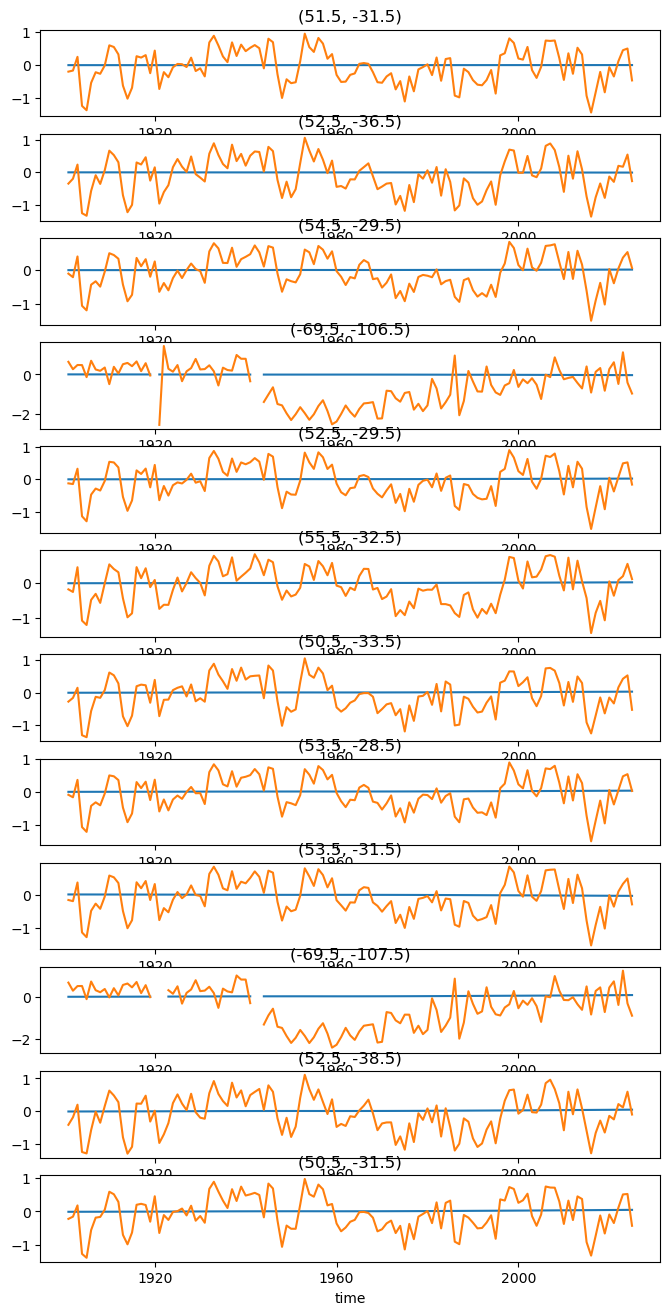

In [110]:
smallest_correlations = correlation_df.iloc[0:60:5, :]

fig = plt.figure(figsize=(8, 16))
axes = [fig.add_subplot( len(smallest_correlations), 1, i+1) for i in range(len(smallest_correlations))]

for num, latlon in enumerate(smallest_correlations.index.values):
    ax = axes[num]
    # subset_ds = data_ds.sel(lat=latlon[0], lon=latlon[1])
    ds_data_signal.sel(lat=latlon[0], lon=latlon[1]).plot(ax=ax)
    data_ds.sel(lat=latlon[0], lon=latlon[1]).plot(ax=ax)
    ax.set_title(latlon)
    ax.set_ylabel('')
    # ax.tick_params(axis='x', fontsize=10)

In [ ]:
total_lat_lon_max =\
    utils.find_nth_extreme_location(
        difference_sn_ks_ds, 'max',
    output_dtype='dict')

In [ ]:

fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
# ax2 = ax1#.twinx()
ds_data_signal.sel(**total_lat_lon_max).plot(ax=ax1, label='signal', color='orange')
ds_data_signal_lowess.sel(**total_lat_lon_max).plot(ax=ax1, label='signal_lowess', color='red')

data_ds.sel(**total_lat_lon_max).plot(ax=ax1, label='Temp', color='green')
ds_data_noise_series.sel(**total_lat_lon_max).plot(ax=ax2, color='blue', label='Noise series')

ds_data_noise_series_lowess.sel(**total_lat_lon_max).plot(ax=ax2, color='lightblue', label='Noise series lowess')

ds_data_sn.sel(**total_lat_lon_max).plot(ax=ax3, color='lightblue', label='Hawkins')
ds_data_sn_lowess.sel(**total_lat_lon_max).plot(ax=ax3, color='blue', label='lowess')
ax3.axhline(1)

ax1.legend()
ax2.legend(loc='upper center')

In [ ]:
plt.scatter(difference_sn_ks_flat, corr_flat)

In [ ]:
signal_data_corr_ds.plot()

### Explorign Odd Patterns

In [ ]:
time_indices = np.array([0, 50, 100])

In [ ]:
ttest_ds = ttest_ds.sortby('lat', ascending=True)

In [ ]:
test_sample_ds = ttest_ds.isel(time=70).sel(lat=slice(-22.5, -10), lon=slice(75, 110))


In [ ]:
min_lat_lon =\
    utils.find_nth_extreme_location(test_sample_ds, 'min',output_dtype='dict')
min_lat_lon

In [ ]:
max_lat_lon =\
    utils.find_nth_extreme_location(test_sample_ds, 'max',output_dtype='dict')
max_lat_lon

In [ ]:
min_time_series = data_ds.sel(**min_lat_lon)
max_time_series = data_ds.sel(**max_lat_lon)

In [ ]:
min_series_pvals = xr.zeros_like(min_time_series) + toe.stats_test_1d_array(min_time_series, stats_func=toe.return_ttest_pvalue)
max_series_pvals = xr.zeros_like(max_time_series) + toe.stats_test_1d_array(max_time_series, stats_func=toe.return_ttest_pvalue)

In [ ]:
def color_yaxis(axis, color, side='left'):
    if not isinstance(axis, list): axis = [axis]
    for ax in axis:
        ax.spines[side].set_color(color)
        ax.tick_params(axis='y', color=color, labelcolor=color)

In [ ]:
fig, (ax1, ax2) = plt.subplots(figsize=(8, 10), nrows=2, ncols=1)

ax1_twinx = ax1.twinx()
min_time_series.plot(ax=ax1, color='blue')
min_series_pvals.plot(ax=ax1_twinx, color='red')
color_yaxis([ax1, ax1_twinx], 'blue', 'left')
color_yaxis([ax1_twinx], 'red', 'right')
ax1_twinx.set_ylabel('P-value', c='red', rotation=0, labelpad=30)
ax1.set_ylabel('Temperature\nAnomaly', c='blue', rotation=0, labelpad=30)

ax2_twinx = ax2.twinx()
max_time_series.plot(ax=ax2, color='blue')
max_series_pvals.plot(ax=ax2_twinx, color='red')
color_yaxis([ax2, ax2_twinx], 'blue', 'left')
color_yaxis([ax2_twinx], 'red', 'right')
ax2_twinx.set_ylabel('P-value', c='red', rotation=0, labelpad=30)
ax2.set_ylabel('Temperature\nAnomaly', c='blue', rotation=0, labelpad=30)

In [ ]:
toe_const.NAME_CONVERSION_DICT

In [ ]:
long_names = list(toe_const.NAME_CONVERSION_DICT)

### Masks Demonstartion

In [ ]:
# grey_white_cmap = mcolors.LinearSegmentedColormap.from_list('grey_white_cmap',  [(1, 1, 1), (0.5, 0.5, 0.5)] , N=2)

In [ ]:
fig = plt.figure(figsize=(12, 6))
axes = [fig.add_subplot(2,2,i, projection=ccrs.PlateCarree()) for i in range(1,5)]

does_not_emerge_ds['signal_to_noise'].plot(ax=axes[0], **not_stable_kwargs2)
does_not_emerge_ds['ks'].plot(ax=axes[1], **not_stable_kwargs2)
does_not_emerge_ds['ttest'].plot(ax=axes[2], **not_stable_kwargs2)
does_not_emerge_ds['anderson'].plot(ax=axes[3], **not_stable_kwargs2)
axes[0].set_title('SN')
axes[1].set_title('KS')
axes[2].set_title('T-test')
axes[3].set_title('Anderson')

NameError: name 'data_unavailability_mask' is not defined

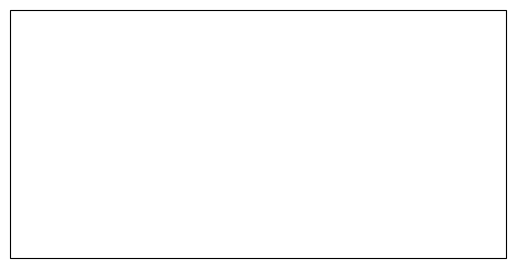

In [117]:
fig = plt.figure()
ax=fig.add_subplot(111, projection=ccrs.PlateCarree())
hatch(ax, data_unavailability_mask, **not_stable_kwargs)

### Correlations and Distributions

In [ ]:
test_pattern_correlation_sn1_df = toe.data_var_pattern_correlation_all_combs(xr.merge([
    toe_sn_multi_thresh_ds.sel(threshold=1), toe_ds[['ks', 'ttest', 'anderson']]]))

In [ ]:
test_pattern_correlation_all_mets_df = toe.data_var_pattern_correlation_all_combs(toe_ds)

In [ ]:
# area_weights = np.cos(np.radians(toe_sn_multi_thresh_ds.lat))
# xr.corr(toe_sn_multi_thresh_ds.sel(threshold=1), toe_ds['ks'], weights=area_weights)

In [ ]:
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(test_pattern_correlation_all_mets_df.iloc[1:, :-1], annot=True, cmap='Blues', fmt='.2f', vmin=0, vmax=1)

# Change the ticks to long names
heatmap.set_xticklabels([toe_const.NAME_CONVERSION_DICT[text.get_text()] for text in heatmap.get_xticklabels()])
heatmap.set_yticklabels([toe_const.NAME_CONVERSION_DICT[text.get_text()] for text in heatmap.get_yticklabels()])

plt.title('Pattern Correlations');
plt.xticks(rotation=45, fontsize=14);  # Rotate x-axis labels for better readability
plt.yticks(rotation=0, fontsize=14) ;  # Keep y-axis labels horizontal

In [ ]:
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(test_pattern_correlation_sn1_df.iloc[1:, :-1], annot=True, cmap='Blues', fmt='.2f', vmin=0, vmax=1)

# Change the ticks to long names
heatmap.set_xticklabels([toe_const.NAME_CONVERSION_DICT[text.get_text()] for text in heatmap.get_xticklabels()])
heatmap.set_yticklabels([toe_const.NAME_CONVERSION_DICT[text.get_text()] for text in heatmap.get_yticklabels()])

plt.title('Pattern Correlations');
plt.xticks(rotation=45);  # Rotate x-axis labels for better readability
plt.yticks(rotation=0) ;  # Keep y-axis labels horizontal

In [ ]:
tests_used = list(toe_ds.data_vars)

fig = plt.figure(figsize=(10, 15))

gs = gridspec.GridSpec(len(tests_used), 1, hspace=0.5)
axes = [fig.add_subplot(gs[i]) for i in range(len(tests_used))]

bins = np.arange(1900, 2025, 5)
for ax, test in zip(axes, tests_used):
    print(test + ', ',  end='')
    ax.grid(alpha=0.5, zorder=0)  # Set z-order for the grid lines
    ax.hist(toe_ds[test].values.flatten(), bins=bins, alpha=0.4, density=True)
    title = toe_const.NAME_CONVERSION_DICT.get(test, test)#toe_ds[test].long_name 
    if test == 'signal_to_noise': title = f'{title} (threshold = 1)'
    ax.set_title(title)
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Relative Frequency', fontsize=12)
    ax.set_ylim([0, 0.05])
    #ax.tick_params(axis='x', size=12)
    


In [ ]:
fig = plt.figure(figsize=(10, 15))

gs = gridspec.GridSpec(len(tests_used)+1, 1, hspace=0.5)
axes = [fig.add_subplot(gs[i]) for i in range(2)]

ax = axes[1]
test = 'ks'
ax.grid(alpha=0.5, zorder=0)  # Set z-order for the grid lines
ax.hist(toe_ds[test].values.flatten(), bins=bins, alpha=0.4, density=True)
title = toe_const.NAME_CONVERSION_DICT.get(test, test)
if test == 'signal_to_noise': title = f'{title} (threshold = 2)'
ax.set_title(title)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Relative Frequency', fontsize=12)
ax.set_ylim([0, 0.05])
    
ax = axes[0]
ax.grid(alpha=0.5, zorder=0)
ax.hist(toe_sn_multi_thresh_ds.sel(threshold=1).values.flatten(), bins=bins, alpha=0.4, density=True);
title = toe_const.NAME_CONVERSION_DICT.get('signal_to_noise', 'signal_to_noise')#toe_ds['signal_to_noise'].long_name
title = f'{title} (threshold = 1)'
ax.set_title(title)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Relative Frequency', fontsize=12)
ax.set_ylim([0, 0.05])

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))


test = 'ks'
ax.grid(alpha=0.5, zorder=1)  # Set z-order for the grid lines
ax.hist(toe_ds[test].values.flatten(), bins=bins, alpha=0.4, density=True, label=toe_const.NAME_CONVERSION_DICT.get(test, test))

    
ax.grid(alpha=0.5, zorder=0)
ax.hist(toe_sn_multi_thresh_ds.sel(threshold=1).values.flatten(), bins=bins, alpha=0.4, density=True, label='signal_to_noise');
ax.set_xlabel('Year')
ax.set_ylabel('Relative Frequency')
ax.set_ylim([0, 0.05])
ax.legend()

In [ ]:
fig = plt.figure(figsize=(10, 14))

gs = gridspec.GridSpec(len(tests_used)+1, 1, hspace=0.5)
axes = [fig.add_subplot(gs[i]) for i in range(len(tests_used)+1)]
bins = np.arange(1900, 2025, 5)
for ax, test in zip(axes[1:], tests_used):
    ax.grid(alpha=0.5, zorder=0)  # Set z-order for the grid lines
    ax.hist(toe_ds[test].values.flatten(), bins=bins, alpha=0.4, density=True)
    title = toe_const.NAME_CONVERSION_DICT.get(test, test) 
    if test == 'signal_to_noise': title = f'{title} (threshold = 2)'
    ax.set_title(title)
    ax.set_xlabel('Year')
    ax.set_ylabel('Relative Frequency')
    ax.set_ylim([0, 0.05])
    
ax = axes[0]
ax.grid(alpha=0.5, zorder=0)
ax.hist(toe_sn_multi_thresh_ds.sel(threshold=1).values.flatten(), bins=bins, alpha=0.4, density=True);
title = toe_const.NAME_CONVERSION_DICT.get('signal_to_noise', 'signal_to_noise')#toe_ds['signal_to_noise'].long_name
title = f'{title} (threshold = 1)'
ax.set_title(title)
ax.set_xlabel('Year')
ax.set_ylabel('Relative Frequency')
ax.set_ylim([0, 0.05])

### Maps

In [ ]:
fig = plt.figure(figsize=(16 * 3/2, 10*(1.2/2.2)))
projection=ccrs.PlateCarree()

gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 1], height_ratios=[.2, 1])
axes = [fig.add_subplot(gs[1, i], projection=projection) for i in range(3)]

not_stable_kwargs2 = dict(cmap= cmap_binary, add_colorbar=False)
toe_plot_kwargs = dict(cmap='RdYlBu',add_colorbar=False, levels=np.arange(1960, 2020, 5))# vmin=1890, vmax=2020) #viridis_r

for ax, threshold in zip(axes, toe_sn_multi_thresh_ds.threshold.values):
    sn_does_not_emerge_multi_thresh_ds.sel(threshold=threshold).plot(ax=ax, **not_stable_kwargs2)
    toe_plot = toe_sn_multi_thresh_ds.sel(threshold=threshold).plot(ax=ax, **toe_plot_kwargs)
    ax.set_title(threshold)
    ax.coastlines()
    hatch(ax, data_unavailability_mask, **not_stable_kwargs)
    
cbar_axes1 = plt.subplot(gs[0, :])
cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='horizontal')

# Add a legend for both the hatching and "Does Not Emerge"
legend_elements = [
    plt.Rectangle([0, 0], 1, 1, fc='white', hatch='//', edgecolor='black', lw=0.5),
    plt.Rectangle([0, 0], 1, 1, fc='grey', alpha=0.5)  # Gray for "Does Not Emerge"
]
legend_labels = ['Not Enough Data', 'Does Not Emerge']
legend = cbar_axes1.legend(legend_elements, legend_labels, loc='upper center', bbox_to_anchor=(0.5, 2), fontsize='large', ncol=2)

In [ ]:
tests_used = ['signal_to_noise', 'ks', 'ttest', 'anderson']
fig = plt.figure(figsize=(16, 10))
projection=ccrs.PlateCarree()

gs = gridspec.GridSpec(4, 2, width_ratios=[1, 1], height_ratios=[.1, .2, 1, 1], hspace=0.0)
axes = [fig.add_subplot(gs[i], projection=projection) for i in range(4, 8)]

not_stable_kwargs2 = dict(cmap=cmap_binary, add_colorbar=False)
toe_plot_kwargs = dict(cmap='RdYlBu',add_colorbar=False, levels=np.arange(1860, 2030, 10))# vmin=1890, vmax=2020) #viridis_r

for ax, test in zip(axes, tests_used):
    does_not_emerge_ds[test].plot(ax=ax, **not_stable_kwargs2)
    toe_plot = toe_ds[test].plot(ax=ax, **toe_plot_kwargs)
    ax.set_title( toe_const.NAME_CONVERSION_DICT.get(test, test) )#toe_ds[test].long_name)
    ax.coastlines()
    hatch(ax, data_unavailability_mask, **not_stable_kwargs)
    
cbar_axes1 = plt.subplot(gs[0, :])
cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='horizontal')
cbar1.ax.set_title('Year of Emergence', fontsize=16)

# Add a legend for both the hatching and "Does Not Emerge"
legend_elements = [
    plt.Rectangle([0, 0], 1, 1, fc='white', hatch='//', edgecolor='black', lw=0.5),
    plt.Rectangle([0, 0], 1, 1, fc='grey', alpha=0.5)  # Gray for "Does Not Emerge"
]
legend_labels = ['Not Enough Data', 'Does Not Emerge']
legend = cbar_axes1.legend(legend_elements, legend_labels, loc='upper center',bbox_to_anchor=(0.5, -0.6), fontsize=12, ncol=2)


In [ ]:
fig = plt.figure(figsize=(8, 10))
projection=ccrs.PlateCarree()

gs = gridspec.GridSpec(4, 1, height_ratios=[.1, .1, 1, 1], hspace=0.2)
axes = [fig.add_subplot(gs[i+2], projection=projection) for i in range(2)]

not_stable_kwargs2 = dict(cmap=cmap_binary, add_colorbar=False)
toe_plot_kwargs = dict(cmap='RdYlBu',add_colorbar=False, levels=np.arange(1860, 2030, 10))# vmin=1890, vmax=2020) #viridis_r

for ax, test in zip(axes, ['signal_to_noise', 'ks']):
    if test == 'signal_to_noise':
        toe_sn_multi_thresh_ds.sel(threshold=1).plot(ax=ax, **toe_plot_kwargs)
        sn_does_not_emerge_multi_thresh_ds.sel(threshold=1).plot(ax=ax, **not_stable_kwargs2)
        title =  toe_const.NAME_CONVERSION_DICT.get(test, test) #toe_ds[test].long_name + ' (threshold=1)'
    else:
        does_not_emerge_ds[test].plot(ax=ax, **not_stable_kwargs2)
        toe_plot = toe_ds[test].plot(ax=ax, **toe_plot_kwargs)
        title =  toe_const.NAME_CONVERSION_DICT.get(test, test) #toe_ds[test].long_name
    ax.set_title(title)
    ax.coastlines()
    hatch(ax, data_unavailability_mask, **not_stable_kwargs)
    
cbar_axes1 = plt.subplot(gs[0, :])
cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='horizontal')
cbar1.ax.set_title('Year of Emergence', fontsize=16)

# Add a legend for both the hatching and "Does Not Emerge"
legend_elements = [
    plt.Rectangle([0, 0], 1, 1, fc='white', hatch='//', edgecolor='black', lw=0.5),
    plt.Rectangle([0, 0], 1, 1, fc='grey', alpha=0.5)  # Gray for "Does Not Emerge"
]
legend_labels = ['Not Enough Data', 'Does Not Emerge']
legend = cbar_axes1.legend(legend_elements, legend_labels, loc='upper center',
                           bbox_to_anchor=(0.5, -1), fontsize=12, ncol=2)


In [ ]:
fig = plt.figure(figsize=(16, 10))
projection=ccrs.PlateCarree()

gs = gridspec.GridSpec(4, 2, width_ratios=[1, 1], height_ratios=[.1, .2, 1, 1], hspace=0.0)
axes = [fig.add_subplot(gs[i], projection=projection) for i in range(4, 8)]

not_stable_kwargs2 = dict(cmap=cmap_binary, add_colorbar=False)
toe_plot_kwargs = dict(cmap='RdYlBu',add_colorbar=False, levels=np.arange(1860, 2030, 10))# vmin=1890, vmax=2020) #viridis_r

for ax, test in zip(axes, tests_used):
    if test == 'signal_to_noise':
        toe_sn_multi_thresh_ds.sel(threshold=1).plot(ax=ax, **toe_plot_kwargs)
        sn_does_not_emerge_multi_thresh_ds.sel(threshold=1).plot(ax=ax, **not_stable_kwargs2)
        title =  toe_const.NAME_CONVERSION_DICT.get(test, test) #toe_ds[test].long_name + ' (threshold=1)'
    else:
        does_not_emerge_ds[test].plot(ax=ax, **not_stable_kwargs2)
        toe_plot = toe_ds[test].plot(ax=ax, **toe_plot_kwargs)
        title =  toe_const.NAME_CONVERSION_DICT.get(test, test) #toe_ds[test].long_name
    ax.set_title(title)
    ax.coastlines()
    hatch(ax, data_unavailability_mask, **not_stable_kwargs)
    
cbar_axes1 = plt.subplot(gs[0, :])
cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='horizontal')
cbar1.ax.set_title('Year of Emergence', fontsize=16)

# Add a legend for both the hatching and "Does Not Emerge"
legend_elements = [
    plt.Rectangle([0, 0], 1, 1, fc='white', hatch='//', edgecolor='black', lw=0.5),
    plt.Rectangle([0, 0], 1, 1, fc='grey', alpha=0.5)  # Gray for "Does Not Emerge"
]
legend_labels = ['Not Enough Data', 'Does Not Emerge']
legend = cbar_axes1.legend(legend_elements, legend_labels, loc='upper center',
                           bbox_to_anchor=(0.5, -0.6), fontsize=12, ncol=2)


In [ ]:
toe_ds['frac'].plot()
does_not_emerge_ds['frac'].plot(**not_stable_kwargs2)

In [ ]:
tests_subset_used = ['signal_to_noise', 'ks', 'frac']

In [ ]:



fig = plt.figure(figsize=(8, 10))
projection=ccrs.PlateCarree()

gs = gridspec.GridSpec(3, 2, width_ratios=[0.1, 1], hspace=0.2, wspace=0.2)
axes = [fig.add_subplot(gs[i, 1], projection=projection) for i in range(3)]

not_stable_kwargs2 = dict(cmap=cmap_binary, add_colorbar=False)
toe_plot_kwargs = dict(cmap='RdYlBu',add_colorbar=False, levels=np.arange(1910, 2030, 10))# vmin=1890, vmax=2020) #viridis_r

for ax, test in zip(axes, tests_used):

    does_not_emerge_ds[test].plot(ax=ax, **not_stable_kwargs2)
    toe_plot = toe_ds[test].plot(ax=ax, **toe_plot_kwargs)
    title =  toe_const.NAME_CONVERSION_DICT.get(test, test) #toe_ds[test].long_name
    ax.set_title(title, fontsize=15)
    ax.coastlines()
    hatch(ax, data_unavailability_mask, **not_stable_kwargs)
    
cbar_axes1 = plt.subplot(gs[:, 0])
cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='vertical')
cbar1.ax.set_title('Year of Emergence', fontsize=16)

# Add a legend for both the hatching and "Does Not Emerge"
legend_elements = [
    plt.Rectangle([0, 0], 1, 1, fc='white', hatch='//', edgecolor='black', lw=0.5),
    plt.Rectangle([0, 0], 1, 1, fc='grey', alpha=0.5)  # Gray for "Does Not Emerge"
]
legend_labels = ['Not Enough Data', 'Does Not Emerge']
legend = cbar_axes1.legend(legend_elements, legend_labels, loc='upper center',
                           bbox_to_anchor=(6, 1.09), fontsize=10, ncol=2)


In [ ]:

tests_used = list(toe_ds.data_vars)

fig = plt.figure(figsize=(16, 14))
projection=ccrs.PlateCarree()

gs = gridspec.GridSpec(5, 2, width_ratios=[1, 1], height_ratios=[.1, .3, 1, 1, 1], hspace=0.0)
axes = [fig.add_subplot(gs[i], projection=projection) for i in range(4, 10)]

not_stable_kwargs2 = dict(cmap=cmap_binary, add_colorbar=False)
toe_plot_kwargs = dict(cmap='RdYlBu',add_colorbar=False, levels=np.arange(1860, 2030, 10))# vmin=1890, vmax=2020) #viridis_r

for ax, test in zip(axes, tests_used):

    does_not_emerge_ds[test].plot(ax=ax, **not_stable_kwargs2)
    toe_plot = toe_ds[test].plot(ax=ax, **toe_plot_kwargs)
    title =  toe_const.NAME_CONVERSION_DICT.get(test, test) #toe_ds[test].long_name
    ax.set_title(title, fontsize=15)
    ax.coastlines()
    hatch(ax, data_unavailability_mask, **not_stable_kwargs)
    
cbar_axes1 = plt.subplot(gs[0, :])
cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='horizontal')
cbar1.ax.set_title('Year of Emergence', fontsize=16)

# Add a legend for both the hatching and "Does Not Emerge"
legend_elements = [
    plt.Rectangle([0, 0], 1, 1, fc='white', hatch='//', edgecolor='black', lw=0.5),
    plt.Rectangle([0, 0], 1, 1, fc='grey', alpha=0.5)  # Gray for "Does Not Emerge"
]
legend_labels = ['Not Enough Data', 'Does Not Emerge']
legend = cbar_axes1.legend(legend_elements, legend_labels, loc='upper center',
                           bbox_to_anchor=(0.5, -1.5), fontsize=12, ncol=2)


In [ ]:
fig = plt.figure(figsize=(8, 12))
projection=ccrs.PlateCarree()

gs = gridspec.GridSpec(3, 2, width_ratios=[1, 0.1], hspace=0.1)
axes = [fig.add_subplot(gs[i, 0], projection=projection) for i in range(3)]

toe_plot_kwargs = dict(cmap='viridis_r',add_colorbar=False, vmin=1890, vmax=2020)

does_not_emerge_ds['signal_to_noise'].plot(ax=axes[0], **not_stable_kwargs2)
does_not_emerge_ds['ks'].plot(ax=axes[1], **not_stable_kwargs2)
np.logical_or(does_not_emerge_ds['ks'], does_not_emerge_ds['signal_to_noise']).plot(ax=axes[2], **not_stable_kwargs2)

toe_ds['signal_to_noise'].plot(ax=axes[0], **toe_plot_kwargs)
toe_plot = toe_ds['ks'].plot(ax=axes[1], **toe_plot_kwargs)

cbar_axes1 = plt.subplot(gs[:2, 1])
cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='vertical')

diff_plot = difference_sn_ks_ds.plot(ax=axes[2], add_colorbar=False, vmin=-20, vmax=20, cmap='RdBu_r')

cbar_axes2 = plt.subplot(gs[2, 1])
cbar2 = plt.colorbar(diff_plot, cax=cbar_axes2, orientation='vertical')

for ax in axes: ax.coastlines()

axes[0].set_title('Signal-to-Noise')
axes[1].set_title('KS Test')
axes[2].set_title('Difference (SN - KS)')

for ax in axes:
    ax.coastlines()
    hatch(ax, data_unavailability_mask, **not_stable_kwargs)


### Point Selection Plots

In [ ]:
data_ds

In [ ]:
total_lat_lon_max =\
    utils.find_nth_extreme_location(
        difference_sn_ks_ds, 'max',
    output_dtype='dict')

In [ ]:
total_lat_lon_max

In [ ]:
fig, ax1 = plt.subplots(1, 1)
ax2 = ax1#.twinx()
ds_data_signal.sel(**total_lat_lon_max).plot(ax=ax1, label='signal', color='orange')
ds_data_sn.sel(**total_lat_lon_max).plot(ax=ax1, label='sn', color='red')

data_ds.sel(**total_lat_lon_max).plot(ax=ax2, label='Temp', color='green')
ds_data_noise_series.sel(**total_lat_lon_max).plot(ax=ax2, color='blue', label='Noise series')

ax1.legend()
ax2.legend(loc='upper center')

In [ ]:
### Asia Targeting

asia_lat_lon_max =\
    utils.find_nth_extreme_location(
        difference_sn_ks_ds.sel(toe_const.LocationBoxes.ASIA.value), 'max',
    output_dtype='dict')

asia_lat_lon_min =\
    utils.find_nth_extreme_location(
        difference_sn_ks_ds.sel(toe_const.LocationBoxes.ASIA.value), 'min',
    output_dtype='dict')

asia_lat_lon_max, asia_lat_lon_min

In [ ]:
# ### North America Targeting

na_lat_lon_max =\
    utils.find_nth_extreme_location(
        difference_sn_ks_ds.sel(toe_const.LocationBoxes.NORTH_AMERICA_LAND_TARGET.value), 'max',
    output_dtype='dict')

na_lat_lon_min = {'lat': 22.5, 'lon': -94.5}

na_lat_lon_min

In [ ]:
ds_data_noise_series.sel(**na_lat_lon_min).plot(color='blue', label='Noise series')


In [ ]:
# fig, ax1 = plt.subplots(1, 1)
# ax2 = ax1#.twinx()
# ds_data_signal.sel(**na_lat_lon_min).plot(ax=ax1, label='signal', color='orange')
# ds_data_sn.sel(**na_lat_lon_min).plot(ax=ax1, label='sn', color='red')

# data_ds.sel(**na_lat_lon_min).plot(ax=ax2, label='Temp', color='green')
# ds_data_noise_series.sel(**na_lat_lon_min).plot(ax=ax2, color='blue', label='Noise series')

# ax1.legend()
# ax2.legend(loc='upper center')

In [ ]:
import time_of_emergence_plots

In [ ]:
fig = plt.figure(figsize=(16, 14))
gs = gridspec.GridSpec(6, 2, hspace=0, height_ratios = [1, 0.1]+ [0.2]*4) 
ax_top = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree())
axes_left = [fig.add_subplot(gs[i+2, 0]) for i in range(4)]
axes_right = [fig.add_subplot(gs[i+2, 1]) for i in range(4)]

time_of_emergence_plots.plot_condition(does_not_emerge_ds.sel(toe_const.LocationBoxes.ASIA.value),
                                       ax_top, 'ks', 'signal_to_noise', **not_stable_kwargs2)

plot = difference_sn_ks_ds.sel(toe_const.LocationBoxes.ASIA.value).plot(ax=ax_top, cmap='RdYlBu_r', vmin=-30, vmax=30, 
                                                                        cbar_kwargs={'label':'Difference (years)'})
# Adjust colorbar label size
cbar = plot.colorbar
cbar.set_label('SN - KS (years)', fontsize=14) 
ax_top.scatter(x=asia_lat_lon_max['lon'], y=asia_lat_lon_max['lat'], marker='x', alpha=.9, s=100, color='blue')
ax_top.scatter(x=asia_lat_lon_min['lon'], y=asia_lat_lon_min['lat'], marker='x', alpha=.9, s=100, color='gold')
hatch(ax_top, data_unavailability_mask.sel(toe_const.LocationBoxes.ASIA.value), **not_stable_kwargs)


plotting_utils.format_lat_lon(ax_top)
ax_top.coastlines()


axes_left[0].set_title('MAX:'+str(na_lat_lon_max) + f'({str(difference_sn_ks_ds.sel(**asia_lat_lon_max).astype(int).values)} years)', 
                       color='blue')
time_of_emergence_plots.plot_multiseries_with_pvalues(toe_metrics_ds.sel(**asia_lat_lon_max, method='nearest'),
                              toe_ds.sel(**asia_lat_lon_max, method='nearest'),
                              data_ds.sel(**asia_lat_lon_max, method='nearest'), 
                             fig=fig, gs=gs, axes=axes_left)


axes_right[0].set_title('MIN:'+str(na_lat_lon_min) + f'({str(difference_sn_ks_ds.sel(**asia_lat_lon_min).astype(int).values)} years)',
                        color='gold')
time_of_emergence_plots.plot_multiseries_with_pvalues(toe_metrics_ds.sel(**asia_lat_lon_min, method='nearest'),
                              toe_ds.sel(**asia_lat_lon_min, method='nearest'),
                              data_ds.sel(**asia_lat_lon_min, method='nearest'), 
                             fig=fig, gs=gs, axes=axes_right)

### Stability Time Series

In [ ]:
REGION_STYLE_DICT = {
    'land': {'color': 'brown', 'linestyle': '--'}, 
    'ocean': {'color': 'blue', 'linestyle': '--'},
    'nh': {'color': 'm', 'linestyle': (0, (1, 1))}, 
    'sh': {'color': 'orange', 'linestyle': (0, (1, 1))},
    'tropics': {'color': 'darkgreen', 'linestyle': '--'}, 
    'mid_lat_nh': {'color': 'red', 'linestyle': '-'}, 
    'mid_lat_sh': {'color': 'tomato', 'linestyle': '--'},
    'arctic': {'color': 'lightblue', 'linestyle': '-'}, 
    'antarctic': {'color': 'darkblue'},
    'global': {'color': 'black', 'linestyle': '-', 'linewidth': 5, 'zorder': 100}
}


In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ks_sn_time_series_diff_ds = (emergence_time_series_ds['ks'] - emergence_time_series_ds['signal_to_noise'])

time = ks_sn_time_series_diff_ds.time.values
for region in ks_sn_time_series_diff_ds.region.values:
    ax.plot(time, ks_sn_time_series_diff_ds.sel(region=region).values, **REGION_STYLE_DICT.get(region, ''),
           label=toe_const.NAMING_MAP.get(region, region))

ax.legend()
ax.set_ylabel('Percent Difference of Land Area Emerged')
ax.set_xlabel('Time')

In [ ]:
emergence_time_series_ds

In [ ]:
region_subset = ['global', 'arctic', 'tropics']

In [ ]:
### Plot Creation

test_subset = tests_subset_used #list(region_emergence_ds.data_vars)
regions = region_subset
nplots = len(regions)
fig = plt.figure(figsize=(20, 3 * nplots))
gs = gridspec.GridSpec(nplots, 1, wspace=0, hspace=0)
axes = [fig.add_subplot(gs[i]) for i in range(nplots)]
# axes.insert(0, fig.add_subplot(gs[0])) # Insert a large subplot at the strage

time = emergence_time_series_ds.time.values

# No emergence before 1930, so can subset
time = list(filter(lambda x: x.year>=1930, time))

for num, region in enumerate(regions):
    print(num)
    ax=axes[num]
    kwargs_to_use ={}#left_kwargs if ((num%2) or (num==0)) else {}
    # for region in regions:
    region_emergence_ds = emergence_time_series_ds.sel(region=region)
    for test in test_subset:
        color = time_of_emergence_plots.TEST_PLOT_DICT.get(test, {}).get('color', 'red')
        label = toe_const.NAME_CONVERSION_DICT.get(test, '')
        ax.plot(time, region_emergence_ds[test].sel(time=region_emergence_ds.time.dt.year>=1930).values,
                color=color, label=label, linewidth=3)
    ax.grid()
    ax.tick_params(axis='y', labelsize=18)
    ax.tick_params(axis='x', labelsize=22)
    number_of_points = int(emergence_time_series_ds.attrs[region]['available'])
    percent_available = (number_of_points/int(emergence_time_series_ds.attrs[region]['maximimum'])) *100
    ax.annotate(toe_const.NAMING_MAP.get(region, region), #+ f' (n={number_of_points}, {percent_available:.0f}%)'
                xy=(0.02, 0.8), size=25, xycoords='axes fraction')

    ax.set_yticks(np.arange(0, 120, 20))
    ax.set_ylim(-10, 110)
    ax.set_xlim(*np.take(time, [0, -1]))


    # Ticks every 20 years
    # Getting just the locations where the year is divisible by 10 with no remainder.
    # Then getting every second one/
    tick_locations = list(filter(lambda t: t.year % 10 == 0, time))[::2]
    ax.set_xticks(tick_locations)
    ax.set_xticklabels(list(map(lambda t:t.year, tick_locations)))

    if num in [0]: ax.xaxis.tick_top()
    if num == 1: ax.set_ylabel('Percent Land Area Emerged (%)', fontsize=22)

    if num == 1: ax.set_xticklabels([]) # Need or the last number can still be seen
    else: ax.set_xlabel('Year', fontsize=22)

# Create the legend
legend = axes[0].legend(ncol=3, loc='center', bbox_to_anchor=(0.5, 1.45), frameon=True, fontsize=22)
frame = legend.get_frame()
frame.set_color('white')  # Set the legend frame color to white
frame.set_edgecolor('black')  # Set the legend frame edge color to black


In [ ]:
### Plot Creation
nplots = len(emergence_time_series_ds.region.values)
fig = plt.figure(figsize=(20, 25))
gs = gridspec.GridSpec(nplots, 1, wspace=0, hspace=0)
axes = [fig.add_subplot(gs[i]) for i in range(nplots)]
# axes.insert(0, fig.add_subplot(gs[0])) # Insert a large subplot at the strage

time = emergence_time_series_ds.time.values

for num, region in enumerate(emergence_time_series_ds.region.values):
    ax=axes[num]
    kwargs_to_use ={}#left_kwargs if ((num%2) or (num==0)) else {}
    # for region in regions:
    region_emergence_ds = emergence_time_series_ds.sel(region=region)
    for test in list(region_emergence_ds.data_vars):
        color = time_of_emergence_plots.TEST_PLOT_DICT.get(test, {}).get('color', 'red')
        label = toe_const.NAME_CONVERSION_DICT.get(test, '')
        ax.plot(time, region_emergence_ds[test].values, color=color, label=label, linewidth=3)
    ax.grid()
    ax.tick_params(axis='y', labelsize=18)
    ax.tick_params(axis='x', labelsize=22)
    number_of_points = int(emergence_time_series_ds.attrs[region]['available'])
    percent_available = (number_of_points/int(emergence_time_series_ds.attrs[region]['maximimum'])) *100
    ax.annotate(toe_const.NAMING_MAP.get(region, region) + f' (n={number_of_points}, {percent_available:.0f}%)', xy=(0.05, 0.8), size=20, xycoords='axes fraction')

    ax.set_yticks(np.arange(0, 120, 20))
    ax.set_ylim(-10, 110)


    # Ticks every 20 years
    # Getting just the locations where the year is divisible by 10 with no remainder.
    # Then getting every second one/
    tick_locations = list(filter(lambda t: t.year % 10 == 0, time))[::2]
    ax.set_xticks(tick_locations)
    ax.set_xticklabels(list(map(lambda t:t.year, tick_locations)))

    if num in [0]:
        print(region)
        ax.xaxis.tick_top()
    if num == 3: ax.set_ylabel('Percent Land Area Emerged', fontsize=22)

    if 2 < num < 8: ax.set_xticklabels([]) # Need or the last number can still be seen
    else: ax.set_xlabel('Year', fontsize=22)

# Create the legend
legend = axes[0].legend(ncol=4, loc='center', bbox_to_anchor=(0.5, 1.45), frameon=True, fontsize=22)
frame = legend.get_frame()
frame.set_color('white')  # Set the legend frame color to white
frame.set_edgecolor('black')  # Set the legend frame edge color to black


In [ ]:
emergence_time_series_ds.attrs[region]

In [ ]:
### Plot Creation
nplots = len(emergence_time_series_ds.region.values)+1
fig = plt.figure(figsize=(12*2, 4*nplots))
gs = gridspec.GridSpec(int(np.ceil(nplots/2))+1, 2, height_ratios=[1.5]+[0.3] + [1]*int(np.ceil((nplots-2)/2)), wspace=0, hspace=0)
ax0 = fig.add_subplot(gs[0, :]); axes = [fig.add_subplot(gs[i+4]) for i in range(nplots-2)]
axes.insert(0, ax0)

time = emergence_time_series_ds.time.values

for num, region in enumerate(emergence_time_series_ds.region.values):
    ax=axes[num]
    kwargs_to_use ={}#left_kwargs if ((num%2) or (num==0)) else {}
    # for region in regions:
    region_emergence_ds = emergence_time_series_ds.sel(region=region)
    for test in list(region_emergence_ds.data_vars):
        color = time_of_emergence_plots.TEST_PLOT_DICT.get(test, {}).get('color', 'red')
        label = toe_const.NAME_CONVERSION_DICT.get(test, '')
        ax.plot(time, region_emergence_ds[test].values, color=color, label=label, linewidth=3)
    ax.grid()
    ax.tick_params(axis='y', labelsize=22)
    ax.tick_params(axis='x', labelsize=22)
    number_of_points = int(emergence_time_series_ds.attrs[region]['available'])
    ax.annotate(toe_const.NAMING_MAP.get(region, region) + f' (n={number_of_points})', xy=(0.05, 0.89), size=30, xycoords='axes fraction')

    ax.set_yticks(np.arange(0, 120, 20))#np.take(ax.get_yticks(), np.arange(1, len(ax.get_yticks())-1)))
    ax.set_ylim(-5, 105)

    # Mticker seems to be broken. Not returning the correct year at the correct points

    # Ticks every 20 years
    # Getting just the locations where the year is divisible by 10 with no remainder.
    # Then getting every second one/
    tick_locations = list(filter(lambda t: t.year % 10 == 0, time))[::2]
    ax.set_xticks(tick_locations)
    ax.set_xticklabels(list(map(lambda t:t.year, tick_locations)))

    if num in [1,2]:
        print(region)
        ax.xaxis.tick_top()
    
    if not num%2 and num >1:
        ax.set_yticklabels([])
        ax.set_ylabel('')
    else: ax.set_ylabel('Percent Land\nArea Emerged', fontsize=22)

    if 2 < num < 8: ax.set_xticklabels([]) # Need or the last number can still be seen
    else: ax.set_xlabel('Year', fontsize=22)

# Create the legend
legend = axes[0].legend(ncol=4, loc='center', bbox_to_anchor=(0.5, 1.06), frameon=True, fontsize=22)
frame = legend.get_frame()
frame.set_color('white')  # Set the legend frame color to white
frame.set_edgecolor('black')  # Set the legend frame edge color to black


### Emergence Correspondense

In [ ]:
from scipy.stats import gaussian_kde

In [ ]:
def generate_histogram(arr: np.ndarray, bins: np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Generate a histogram from the input array.

    Parameters:
    arr (np.ndarray): The input array to generate the histogram from.
    bins (np.ndarray): The bin edges for the histogram.

    Returns:
    tuple[np.ndarray, np.ndarray, np.ndarray]: A tuple containing the bin centers, the histogram values, and the histogram normalization factor.
    """
    # Remove NaN values from the input array
    vals = arr[np.isfinite(arr)]
    
    # Generate the histogram
    hist, bin_edges = np.histogram(vals, bins=bins, density=True)
    
    # Calculate the histogram normalization factor
    hist_norm = np.sum(hist)
    
    # Normalize the histogram
    hist = hist/hist_norm
    
    # Calculate the bin centers
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    return bin_centers, hist, hist_norm


def generate_kde(arr: np.ndarray, hist_norm: float, bin_edges: np.ndarray) -> tuple[gaussian_kde, np.ndarray]:
    """
    Generate a kernel density estimate (KDE) from the input array.

    Parameters:
    arr (np.ndarray): The input array to generate the KDE from.
    hist_norm (float): The histogram normalization factor.
    bin_edges (np.ndarray): The bin edges for the histogram.

    Returns:
    tuple[gaussian_kde, np.ndarray]: A tuple containing the KDE generator and the normalized KDE values.
    """
    # Generate the KDE
    arr = arr[np.isfinite(arr)]
    kde_generator = gaussian_kde(arr)
    
    # Generate a grid of x values for the KDE
    x_grid = np.linspace(bin_edges[0], bin_edges[-1], 1000)
    
    # Evaluate the KDE at the x grid points
    kde_values = kde_generator(x_grid)
    
    # Normalize the KDE values
    kde_values_normalized = kde_values/hist_norm
    
    return kde_generator, kde_values_normalized

In [ ]:
def plot_histogram(bin_centers, histogram, histogram_norm, kde_generator, kde_values_normalized,
                   data, fig=None, ax=None, *args, **kwargs):
    """
    Plots a histogram and kernel density estimate (KDE) for the input data.

    Parameters:
    bin_centers (array): The bin centers for the histogram.
    histogram (array): The histogram values.
    histogram_norm (float): The normalization factor for the histogram.
    kde_generator (function): The KDE generator function.
    kde_values_normalized (array): The normalized KDE values.
    data (DataFrame): The input data.

    Returns:
    fig, ax (tuple): The figure and axis objects for the plot.
    """
    if fig is None and ax is None:
        fig, ax = plt.subplots()

    # Plot the histogram with bars of width equal to the bin width
    # (accounting for floating point errors)
    ax.bar(bin_centers, histogram, width=np.unique(np.diff(bin_centers))[0].round(2), alpha=0.5)
    
    # Generate x values for the KDE plot
    x_grid = np.linspace(bin_centers[0], bin_centers[-1], 1000)
    
    # Plot the KDE
    ax.plot(x_grid, kde_values_normalized, label='KDE', color='black')
    
    # Set the axis labels and title
    ax.set_ylabel('Relative Frequency', fontsize=20)
    ax.set_xlabel(kwargs.get('xlabel','Value'))
    ax.grid(True, alpha=0.3, color='grey', linestyle='--')

    # Calculate and plot the quantiles
    quantiles = {}
    percentiles = [0.05, 0.25, 0.5, 0.75, 0.95]
    for q in percentiles:
        qval = np.nanpercentile(data, q*100).round(2).item()
        quantiles[q] = qval
        rf_val = kde_generator(qval).item()/ histogram_norm
        if q==0.5: style_dict = dict(linewidth=3, color='k')
        elif q==0.25 or q==0.75: style_dict = dict(linewidth=2, color='k', linestyle='--')
        elif q ==percentiles[0] or q==percentiles[-1]: style_dict = dict(linewidth=2, color='k', linestyle=':')

        # Plot the quantiles as vertical lines
        ax.plot([qval, qval], [0, rf_val], **style_dict)

        # round_number = lambda n: round(n - 0.05) if n % 10 != 0 else round(n)
        # ax.annotate(round_number(qval), xy=(qval+0.025*np.max(bincenters), 0),
        #             size=16, ha='center')

    print(quantiles)
    
    return fig, ax

In [ ]:
def calculate_and_plot_histogram(data, bins, fig=None, ax=None, **kwargs):
    """
    Plots the distribution of values.

    Parameters:
    data (array-like): The data to plot.
    bins (array-like): The bins for the histogram.
    xlabel (str, optional): The label for the x-axis. Defaults to 'Distribution Overlap (%)'.

    Returns:
    fig, ax: The figure and axis objects for the plot.
    """
    bin_centers, histogram, histogram_norm = generate_histogram(data.flatten(), bins)
    kde_generator, kde_values_normalized = generate_kde(data.flatten(), histogram_norm, bin_centers)
    fig, ax = plot_histogram(bin_centers, histogram, histogram_norm, kde_generator, kde_values_normalized, 
                             data, fig=fig, ax=ax)
    
    ax.set_title(kwargs.get('title', ''), fontsize=25)
    ax.set_xlabel(kwargs.get('xlabel', ''), fontsize=20)

    return fig, ax

In [ ]:
bins = np.arange(0, 101, 1)
fig, ax = calculate_and_plot_histogram(overlap_at_sn_emergence_ds.values, bins, 
                           title='Overlap at S/N Ratio Emergence', xlabel='Distribution Overlap (%)')

In [ ]:
overlap_ks_bins = np.arange(0, 101, 1)
fig, ax = calculate_and_plot_histogram(overlap_at_ks_emergence_ds.values, overlap_ks_bins, 
                           title='Overlap at KS Emergence', xlabel='Distribution Overlap (%)')

In [ ]:
snr_bins = np.arange(-0.5, 2.5, .03)
fig, ax = calculate_and_plot_histogram(sn_at_overlap_emergence_ds.values, snr_bins, 
                           title='S/N Ratio and Overlap Emergence', xlabel='Signal-to-Noise Ratio')

In [ ]:
snr_bins = np.arange(-0.5, 2.5, .03)
fig, ax = calculate_and_plot_histogram(sn_at_ks_emergence_ds.values, snr_bins, 
                           title='S/N Ratio and KS Emergence', xlabel='Signal-to-Noise Ratio')

In [ ]:
not_stable_kwargs3 = {'cmap':cmap_binary, 'add_colorbar':False}

In [ ]:
min_lat_lon_sn_at_kas =\
    utils.find_nth_extreme_location(sn_at_ks_emergence_ds, 'min',output_dtype='dict')
min_lat_lon_sn_at_kas

In [ ]:
max_lat_lon_sn_at_kas =\
    utils.find_nth_extreme_location(sn_at_ks_emergence_ds, 'max',output_dtype='dict')
max_lat_lon_sn_at_kas

In [ ]:
fig, gs, axes = time_of_emergence_plots.plot_multiseries_with_pvalues(toe_metrics_ds.sel(**max_lat_lon_sn_at_kas, method='nearest'),
                              toe_ds.sel(**max_lat_lon_sn_at_kas, method='nearest'),
                              data_ds.sel(**max_lat_lon_sn_at_kas, method='nearest'), return_figure=True)
axes[0].set_title(max_lat_lon_sn_at_kas);

In [ ]:
# Veriftying for a single point
signal_sp2, noise_series_sp2, reocnstructed_sp2 =\
    toe.return_hawkins_signal_and_noise(
        data_ds.sel(max_lat_lon_sn_at_kas, method='nearest').values,
         gt=data_ds_smean_lowess.values,
        return_reconstruction=True)

In [ ]:
plt.plot(reocnstructed_sp2, label='reconstructed')
plt.plot(data_ds.sel(max_lat_lon_sn_at_kas, method='nearest').values, label='original')
plt.plot(signal_sp2, label='signal')
plt.plot(signal_sp2/np.nanstd(noise_series_sp2), label='signal-to-noise ratio')
plt.legend()

In [ ]:
# Load in the custome levels and cmaps that I have made for these plots
levels_sn, cmap_sn = time_of_emergence_plots.generate_sn_colormap_and_levels()
levels_overlap, cmap_overlap = time_of_emergence_plots.generate_overlap_colormap_and_levels()
print(levels_overlap)
cmap_overlap

In [ ]:
reload(time_of_emergence_plots)

In [ ]:
fig = plt.figure(figsize=(24, 14))
gs = gridspec.GridSpec(4, 2, height_ratios=[0.1, 0.05, 1, 1])

axes_right = [
    fig.add_subplot(gs[i+2, 1], projection=ccrs.PlateCarree()) 
    for i in range(2)]
axes_left = [
    fig.add_subplot(gs[i+2, 0], projection=ccrs.PlateCarree()) 
    for i in range(2)]

#### Not enough data points
# Note: this comes first so it does not mess with my titles
time_of_emergence_plots.plot_condition(does_not_emerge_ds, axes_right[0], 'frac', 'ks', **not_stable_kwargs3)
time_of_emergence_plots.plot_condition(does_not_emerge_ds, axes_right[1], 'frac', 'signal_to_noise', **not_stable_kwargs3)
time_of_emergence_plots.plot_condition(does_not_emerge_ds, axes_left[0], 'frac', 'ks', **not_stable_kwargs3)
time_of_emergence_plots.plot_condition(does_not_emerge_ds, axes_left[1], 'frac', 'signal_to_noise', **not_stable_kwargs3)

#### LEFT AXIS

for num, ds in enumerate([sn_at_ks_emergence_ds, sn_at_overlap_emergence_ds]):
    ax = axes_left[num]
    toe_plot_left = ax.contourf(
        ds.lon, ds.lat, ds.values, cmap=cmap_sn, levels=levels_sn, extend='both'
    )
    hatch(ax, data_unavailability_mask, **not_stable_kwargs)
    ax.coastlines()
    ax.set_title(ds.long_name, fontsize=20)

cbar_axes_left = plt.subplot(gs[0, 0])
cbar_left = plt.colorbar(toe_plot_left, cax=cbar_axes_left, orientation='horizontal')
cbar_left.ax.set_title('Signal-to-Noise Ratio', fontsize=18)
cbar_left.ax.set_xticks(levels_sn)

### RIGHT AXIS


for num, ds in enumerate([overlap_at_ks_emergence_ds, overlap_at_sn_emergence_ds]):
    ax = axes_right[num]
    toe_plot_right = ax.contourf(
        ds.lon, ds.lat, ds.values, cmap=cmap_overlap, 
        levels=levels_overlap, extend='min'
    )
    hatch(ax, data_unavailability_mask, **not_stable_kwargs)
    ax.coastlines()
    ax.set_title(ds.long_name, fontsize=20)

cbar_axes_right = plt.subplot(gs[0, 1])
cbar_right = plt.colorbar(toe_plot_right, cax=cbar_axes_right, orientation='horizontal')
cbar_right.ax.set_title('Overlap (%)', fontsize=18)
cbar_right.ax.set_xticks(levels_overlap)


# Create the legend between the two colorbars
legend_elements = [
    plt.Rectangle([0, 0], 1, 1, fc='white', hatch='//', edgecolor='black', lw=0.5),
    plt.Rectangle([0, 0], 1, 1, fc='grey', alpha=0.5)  
]
legend_labels = ['Not Enough Data', 'Does Not Emerge']

fig.legend(
    legend_elements, legend_labels, loc='upper center', 
    bbox_to_anchor=(0.5, 0.82), fontsize=16, ncol=2
)


In [ ]:
fig = plt.figure(figsize=(15, 7))
gs = gridspec.GridSpec(1, 2,  width_ratios=[0.05, 1], wspace=0.2)

ax = fig.add_subplot(gs[1], projection=ccrs.PlateCarree())


time_of_emergence_plots.plot_condition(does_not_emerge_ds, ax, 'frac', 'ks', **not_stable_kwargs3)


ds = overlap_at_ks_emergence_ds
toe_plot_right = ax.contourf(
        ds.lon, ds.lat, ds.values, cmap=cmap_overlap, 
        levels=levels_overlap, extend='min'
    )
hatch(ax, data_unavailability_mask, **not_stable_kwargs)
ax.coastlines()
ax.set_title(ds.long_name, fontsize=25)

cbar_axes_left2 = plt.subplot(gs[0])
cbar_right = plt.colorbar(toe_plot_right, cax=cbar_axes_left2, orientation='vertical')
cbar_right.ax.set_ylabel('Overlap (%)', fontsize=18)
cbar_right.ax.set_yticks(levels_overlap)
cbar_right.ax.tick_params(labelsize=18)


# Create the legend between the two colorbars
legend_elements = [
    plt.Rectangle([0, 0], 1, 1, fc='white', hatch='//', edgecolor='black', lw=0.5),
    plt.Rectangle([0, 0], 1, 1, fc='grey', alpha=0.5)  
]
legend_labels = ['Not Enough Data', 'Does Not Emerge']

fig.legend(
    legend_elements, legend_labels, loc='upper center', 
    bbox_to_anchor=(0.55, 1), fontsize=16, ncol=2
)

In [ ]:
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[0.1, 1])
ax = fig.add_subplot(gs[1], projection=ccrs.PlateCarree())

toe_plot = sn_at_ks_emergence_ds.plot(ax=ax, robust=True, cmap=cmap_sn, 
                                      add_colorbar=False, levels=levels_sn)
hatch(ax, data_unavailability_mask, **not_stable_kwargs)
does_not_emerge_ds['ks'].plot(**not_stable_kwargs3)

cbar_axes1 = plt.subplot(gs[0])
cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='horizontal')
cbar1.ax.set_title('Signal-to-noise Ratio', fontsize=14)
cbar1.ax.set_xticks(levels_sn)
# Add a legend for both the hatching and "Does Not Emerge"
legend_elements = [
    plt.Rectangle([0, 0], 1, 1, fc='white', hatch='//', edgecolor='black', lw=0.5),
    plt.Rectangle([0, 0], 1, 1, fc='grey', alpha=0.5)  # Gray for "Does Not Emerge"
]
legend_labels = ['Not Enough Data', 'Does Not Emerge']
legend = cbar_axes1.legend(legend_elements, legend_labels, loc='upper center',bbox_to_anchor=(0.5, -0.5), fontsize=14, ncol=2)
ax.coastlines()
ax.set_title('')

In [ ]:
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[0.1, 1])
ax = fig.add_subplot(gs[1], projection=ccrs.PlateCarree())

toe_plot = overlap_at_ks_emergence_ds.plot(ax=ax, robust=True, cmap=cmap_overlap, 
                                      add_colorbar=False, levels=levels_overlap)
hatch(ax, data_unavailability_mask, **not_stable_kwargs)
does_not_emerge_ds['ks'].plot(**not_stable_kwargs3)

cbar_axes1 = plt.subplot(gs[0])
cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='horizontal')
cbar1.ax.set_title('Overlap (%)', fontsize=14)
cbar1.ax.set_xticks(levels_overlap)
# Add a legend for both the hatching and "Does Not Emerge"
legend_elements = [
    plt.Rectangle([0, 0], 1, 1, fc='white', hatch='//', edgecolor='black', lw=0.5),
    plt.Rectangle([0, 0], 1, 1, fc='grey', alpha=0.5)  # Gray for "Does Not Emerge"
]
legend_labels = ['Not Enough Data', 'Does Not Emerge']
legend = cbar_axes1.legend(legend_elements, legend_labels, loc='upper center',bbox_to_anchor=(0.5, -0.5), fontsize=14, ncol=2)
ax.coastlines()
ax.set_title('')

In [ ]:
fig = plt.figure(figsize=(20, 7))
gs = gridspec.GridSpec(1, 3,  width_ratios=[0.05, 1, 1], wspace=0.2)

ax = fig.add_subplot(gs[1], projection=ccrs.PlateCarree())


time_of_emergence_plots.plot_condition(does_not_emerge_ds, ax, 'frac', 'ks', **not_stable_kwargs3)


ds = overlap_at_ks_emergence_ds
toe_plot_right = ax.contourf(
        ds.lon, ds.lat, ds.values, cmap=cmap_overlap, 
        levels=levels_overlap, extend='min'
    )
hatch(ax, data_unavailability_mask, **not_stable_kwargs)
ax.coastlines()
ax.set_title(ds.long_name, fontsize=25)

cbar_axes_left2 = plt.subplot(gs[0])
cbar_right = plt.colorbar(toe_plot_right, cax=cbar_axes_left2, orientation='vertical')
cbar_right.ax.set_ylabel('Overlap (%)', fontsize=18)
cbar_right.ax.set_yticks(levels_overlap)
cbar_right.ax.tick_params(labelsize=18)


# Create the legend between the two colorbars
legend_elements = [
    plt.Rectangle([0, 0], 1, 1, fc='white', hatch='//', edgecolor='black', lw=0.5),
    plt.Rectangle([0, 0], 1, 1, fc='grey', alpha=0.5)  
]
legend_labels = ['Not Enough Data', 'Does Not Emerge']

fig.legend(
    legend_elements, legend_labels, loc='upper center', 
    bbox_to_anchor=(0.35, 0.94), fontsize=16, ncol=2
)

########
axes_right = fig.add_subplot(gs[2])

bins = np.arange(0, 101, 1)
overlap_ks_bins = np.arange(0, 101, 1)
snr_bins = np.arange(-0.5, 2.5, .03)




calculate_and_plot_histogram(overlap_at_ks_emergence_ds.values, overlap_ks_bins,  ax=axes_right,
                           # title='Overlap at KS Emergence', 
                             xlabel='Distribution Overlap (%)')




In [ ]:
fig = plt.figure(figsize=(28, 25))
gs = gridspec.GridSpec(4, 3, height_ratios=[1, 1] * 2, width_ratios=[0.05, 1, 1], wspace=0.02, hspace=0.3)

# axes_right = [
#     fig.add_subplot(gs[i+2, 1], projection=ccrs.PlateCarree()) 
#     for i in range(2)]
axes_left = [
    fig.add_subplot(gs[i, 1], projection=ccrs.PlateCarree()) 
    for i in np.arange(4)]

#### Not enough data points
# Note: this comes first so it does not mess with my titles
time_of_emergence_plots.plot_condition(does_not_emerge_ds, axes_left[0], 'frac', 'ks', **not_stable_kwargs3)
time_of_emergence_plots.plot_condition(does_not_emerge_ds, axes_left[1], 'frac', 'signal_to_noise', **not_stable_kwargs3)
time_of_emergence_plots.plot_condition(does_not_emerge_ds, axes_left[2], 'frac', 'ks', **not_stable_kwargs3)
time_of_emergence_plots.plot_condition(does_not_emerge_ds, axes_left[3], 'frac', 'signal_to_noise', **not_stable_kwargs3)

#### LEFT AXIS

for num, ds in enumerate([sn_at_ks_emergence_ds, sn_at_overlap_emergence_ds]):
    ax = axes_left[num]
    toe_plot_left = ax.contourf(
        ds.lon, ds.lat, ds.values, cmap=cmap_sn, levels=levels_sn, extend='both'
    )
    hatch(ax, data_unavailability_mask, **not_stable_kwargs)
    ax.coastlines()
    ax.set_title(ds.long_name, fontsize=25)

cbar_axes_left = plt.subplot(gs[0:2, 0])
cbar_left = plt.colorbar(toe_plot_left, cax=cbar_axes_left, orientation='vertical')
cbar_left.ax.set_ylabel('Signal-to-Noise Ratio', fontsize=25)
cbar_left.ax.set_yticks(levels_sn)
cbar_left.ax.tick_params(labelsize=18)
### RIGHT AXIS


for num, ds in enumerate([overlap_at_ks_emergence_ds, overlap_at_sn_emergence_ds]):
    ax = axes_left[num+2]
    toe_plot_right = ax.contourf(
        ds.lon, ds.lat, ds.values, cmap=cmap_overlap, 
        levels=levels_overlap, extend='min'
    )
    hatch(ax, data_unavailability_mask, **not_stable_kwargs)
    ax.coastlines()
    ax.set_title(ds.long_name, fontsize=25)

cbar_axes_left2 = plt.subplot(gs[2:4, 0])
cbar_right = plt.colorbar(toe_plot_right, cax=cbar_axes_left2, orientation='vertical')
cbar_right.ax.set_ylabel('Overlap (%)', fontsize=25)
cbar_right.ax.set_yticks(levels_overlap)
cbar_right.ax.tick_params(labelsize=18)


# Create the legend between the two colorbars
legend_elements = [
    plt.Rectangle([0, 0], 1, 1, fc='white', hatch='//', edgecolor='black', lw=0.5),
    plt.Rectangle([0, 0], 1, 1, fc='grey', alpha=0.5)  
]
legend_labels = ['Not Enough Data', 'Does Not Emerge']

fig.legend(
    legend_elements, legend_labels, loc='upper center', 
    bbox_to_anchor=(0.35, 0.94), fontsize=20, ncol=2
)

########
axes_right = [fig.add_subplot(gs[i, 2]) for i in np.arange(4)]

bins = np.arange(0, 101, 1)
overlap_ks_bins = np.arange(0, 101, 1)
snr_bins = np.arange(-0.5, 2.5, .03)


calculate_and_plot_histogram(sn_at_ks_emergence_ds.values, snr_bins,  ax=axes_right[0],
                           # title='S/N Ratio and KS Emergence',
                             xlabel='Signal-to-Noise Ratio')

calculate_and_plot_histogram(sn_at_overlap_emergence_ds.values, snr_bins,  ax=axes_right[1],
                           # title='S/N Ratio and Overlap Emergence', 
                             xlabel='Signal-to-Noise Ratio')


calculate_and_plot_histogram(overlap_at_ks_emergence_ds.values, overlap_ks_bins,  ax=axes_right[2],
                           # title='Overlap at KS Emergence', 
                             xlabel='Distribution Overlap (%)')

calculate_and_plot_histogram(overlap_at_sn_emergence_ds.values, bins, ax=axes_right[3],
                           # title='Overlap at S/N Ratio Emergence', 
                             xlabel='Distribution Overlap (%)')


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
overlap_at_sn_emergence_ds.sel(lat=slice(-90, -50), lon=slice(-90, -60)).plot(ax=ax)
ax.coastlines()

# Add gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Set gridlines' linestyle and color
gl.xlines = True
gl.ylines = True
gl.linestyle = '--'
gl.color = 'gray'

In [ ]:
min_overlap_kwargs = dict(lat=-59, lon=-72.5, method='nearest')

In [ ]:
toe_ds.sel(**min_overlap_kwargs).to_array(name='test')

In [ ]:
overlap_at_sn_emergence_ds.sel(**min_overlap_kwargs)

In [ ]:
start_select_data = data_ds.sel(**min_overlap_kwargs).where(data_ds.time.dt.year.isin(np.arange(*start_end_tuple)), drop=True)

In [ ]:
overlap_emergence_select_data = data_ds.sel(**min_overlap_kwargs).where(data_ds.time.dt.year.isin(np.arange(1934, 1954)), drop=True)

In [ ]:
sn_emergence_select_data = data_ds.sel(**min_overlap_kwargs).where(data_ds.time.dt.year.isin(np.arange(1979, 1999)), drop=True)

In [ ]:
toe_metrics_ds.sel(**min_overlap_kwargs)['signal_to_noise'].sel(time=toe_metrics_ds.time.dt.year==1944).values

In [ ]:
toe.farctional_geometric_area(start_select_data.values, overlap_emergence_select_data.values)

In [ ]:
toe.farctional_geometric_area(start_select_data.values, sn_emergence_select_data.values)

In [ ]:
np.mean(sn_emergence_select_data).values

In [ ]:
def generate_kde2(arr: np.ndarray, vmin, vmax) -> tuple[gaussian_kde, np.ndarray]:
    """
    Generate a kernel density estimate (KDE) from the input array.

    Parameters:
    arr (np.ndarray): The input array to generate the KDE from.
    hist_norm (float): The histogram normalization factor.
    bin_edges (np.ndarray): The bin edges for the histogram.

    Returns:
    tuple[gaussian_kde, np.ndarray]: A tuple containing the KDE generator and the normalized KDE values.
    """
    # Generate the KDE
    arr = arr[np.isfinite(arr)]
    kde_generator = gaussian_kde(arr)
    
    # Generate a grid of x values for the KDE
    x_grid = np.linspace(vmin, vmax, 1000)
    
    # Evaluate the KDE at the x grid points
    kde_values = kde_generator(x_grid)
    
    return x_grid, kde_values

In [ ]:
x_grid, start_select_kde = generate_kde2(start_select_data.values, vmin=-1, vmax=2)
x_grid, sn_emergence_select_kde = generate_kde2(sn_emergence_select_data.values, vmin=-1, vmax=2)
x_grid, overlap_emergence_select_kde = generate_kde2(overlap_emergence_select_data.values, vmin=-1, vmax=2)

In [ ]:
np.mean(overlap_emergence_select_data.values)

In [ ]:
plt.plot(x_grid, start_select_kde)
plt.plot(x_grid, sn_emergence_select_kde)
plt.plot(x_grid, overlap_emergence_select_kde)

In [ ]:
plt.hist(start_select_data.values, density=True)
plt.hist(sn_emergence_select_data.values, density=True)

In [ ]:
plt.hist(start_select_data.values)
plt.hist(overlap_emergence_select_data.values)

In [ ]:
data_ds.sel(**min_overlap_kwargs).plot()

# Part II: Component wise emergence

In [ ]:
from scipy.stats import cramervonmises

In [ ]:
lowess_ds = xr.apply_ufunc(
    stats.apply_lowess, 
    data_ds.chunk({'time':-1, 'lat':10}), 
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True, 
    dask='parallelized',    
).compute()


In [ ]:
data_detrend_ds = data_ds - lowess_ds

In [ ]:
import pymannkendall

In [ ]:
data_detrend_rolling_std = data_detrend_ds.rolling(time=20).std(dim='time')

In [ ]:
pymannkendall(np.arange(100))

In [ ]:
trend_std = xr.apply_ufunc(
    pymannkendall, 
    data_detrend_rolling_std,
    input_core_dims=[['time']], 
    output_core_dims=[[]], 
    vectorize=True
)

In [ ]:
data_ds_detrend_window = (data_detrend_ds
                  .chunk(CHUNKS_FOR_PVALUE_TESTS)
                  .rolling(time=window, center=True, min_periods=window)
                  .construct('window_dim')
                  .persist()) 

base_period_detrend_window_ds = (data_detrend_ds.where(data_detrend_ds.time == base_period_ds.time, drop=True)
                         .chunk(CHUNKS_FOR_PVALUE_TESTS)
                         .rename({'time':'window_dim'})
                         .persist())

In [ ]:
%%time
ks_detrend_ds = xr.apply_ufunc(
        toe.return_ks_pvalue,
        data_ds_detrend_window,
        base_period_detrend_window_ds,
    **rolling_window_kwargs
    ).compute()

In [ ]:
ks_detrend_ds = ks_detrend_ds.isel(time=slice(int(window/2), -int(window/2)))

In [ ]:
%%time
anderson_detrend_ds = xr.apply_ufunc(
        toe.return_anderson_pvalue,
        data_ds_detrend_window,
        base_period_detrend_window_ds,
    **rolling_window_kwargs
    ).compute()

In [ ]:
anderson_detrend_ds = anderson_detrend_ds.isel(time=slice(int(window/2), -int(window/2)))

In [ ]:
# New Component wise emergence
ks_detrend_toe_ds = toe.get_permanent_exceedance(ks_detrend_ds, threshold=PVALUE_THESHOLD1,
                                                    comparison_func=np.less)

anderson_detrend_toe_ds = toe.get_permanent_exceedance(anderson_detrend_ds, threshold=PVALUE_THESHOLD1,
                                                    comparison_func=np.less)

In [ ]:
shape_emerges_somehwere_ds = xr.where(np.isfinite(ks_detrend_toe_ds), 1, 0) + xr.where(np.isfinite(anderson_detrend_toe_ds), 1, 0)

In [ ]:
shape_emerges_somehwere_ds.plot()

In [ ]:
ks_detrend_ds.sel(lat=-38, lon=144, method='nearest').plot()

In [ ]:
ks_detrend_toe_ds.count()

In [ ]:
ks_detrend_toe_ds.plot.hist(bins=np.arange(1980, 2030, 2))

In [ ]:
ks_detrend_toe_ds.plot()

In [ ]:
toe_with_shape_emergence_ds = toe_ds['ks'].where(np.isfinite(ks_detrend_toe_ds))
toe_without_shape_emergenc_ds = toe_ds['ks'].where(np.isnan(ks_detrend_toe_ds))

In [ ]:
sn_ks_diff = toe_ds['ks'] - toe_ds['signal_to_noise']

In [ ]:
diff_with_shape_emergence_ds = sn_ks_diffwhere(np.isfinite(ks_detrend_toe_ds))
diff_without_shape_emergenc_ds = sn_ks_diff.where(~np.isfinite(ks_detrend_toe_ds))

In [ ]:
diff_with_shape_emergence_ds = sn_ks_diffwhere(np.isfinite(ks_detrend_toe_ds))
diff_without_shape_emergenc_ds = sn_ks_diff.where(~np.isfinite(ks_detrend_toe_ds))

In [ ]:
plt.hist(diff_with_shape_emergence_ds)
plt.hist(diff_without_shape_emergenc_ds)

## Old

In [ ]:
# %%time
# levene_detrend_ds = xr.apply_ufunc(
#         toe.return_levene_pvalue,
#         data_ds_detrend_window,
#         base_period_detrend_window_ds,
#     **rolling_window_kwargs
#     ).compute()

In [ ]:
import statsmodels.api as sm

def test_for_heteroscedasticity(y, X):
    if np.all(np.isnan(y)): return np.nan, np.nan
    idy = np.isfinite(y)
    y = y[idy]
    X = X[idy]
    X = sm.add_constant(X)  # Add a constant term (intercept)
    het_vals = sm.stats.het_breuschpagan(y, X)
    return het_vals[0], het_vals[1]

het_score, het_pvalue = xr.apply_ufunc(
    partial(test_for_heteroscedasticity,X = np.arange(len(ds_data_noise_series.time.values))),
    ds_data_noise_series,
    input_core_dims=[['time']],
    output_core_dims=[[], []],
    vectorize=True
)

In [ ]:
het_occured = xr.where(np.logical_and(het_score>0.9, het_pvalue<0.05), 1, 0)

In [ ]:
het_occured.plot()

In [ ]:
# New Component wise emergence
levene_detrend_toe_ds = toe.get_permanent_exceedance(levene_detrend_ds, threshold=PVALUE_THESHOLD1,
                                                    comparison_func=np.less)
mannwhitney_toe_ds = toe.get_permanent_exceedance(mannwhitney_ds, threshold=PVALUE_THESHOLD1,
                                                    comparison_func=np.less)

In [ ]:
%%time
mannwhitney_ds = xr.apply_ufunc(
        toe.return_mannwhitney_pvalue,
        data_ds_window,
        base_period_window_ds,
    output_dtypes=float,
    **rolling_window_kwargs
    ).compute()

In [ ]:
anderson_detrend_ds = xr.apply_ufunc(
    toe.return_anderson_pvalue,
    data_ds_detrend_window,
    base_period_detrend_window_ds,
    output_dtypes=float, 
    **rolling_window_kwargs
    ).compute()

In [ ]:
(toe_sn_multi_thresh_ds.sel(threshold=1) -toe_ds['ks']).plot.hist()

In [ ]:
fig, ax = plt.subplots()

ax.scatter(toe_sn_multi_thresh_ds.sel(threshold=1).values.flatten(), toe_ds['ks'].values.flatten())
ax.set_xlim(1900, 2020)
ax.set_ylim(1900, 2020)
ax.plot(np.arange(1900, 2020), np.arange(1900, 2020), c='k')

In [ ]:
snr_ks_diff = toe_sn_multi_thresh_ds.sel(threshold=1) -toe_ds['ks']

In [ ]:
# ds_data_noise ,ds_data_sn ,ds_data_signal ,ds_data_noise_series

In [ ]:
from scipy.stats import spearmanr

In [ ]:
spearmanr(snr_ks_diff.values.flatten(), ds_data_noise.values.flatten(), nan_policy='omit')

In [ ]:
spearmanr(snr_ks_diff.values.flatten(), ds_data_noise.values.flatten(), nan_policy='omit')

In [ ]:
plt.scatter(snr_ks_diff.values.flatten(), ds_data_noise.values.flatten())

In [ ]:
ds_data_rolling_noise_series = ds_data_noise_series.rolling(time=20).std()

ds_data_var = ds_data_rolling_noise_series.std(dim='time') 

In [ ]:
plt.scatter(snr_ks_diff.values.flatten(), ds_data_var.values.flatten())

In [ ]:
plt.scatter(snr_ks_diff.values.flatten(), het_pval.values.flatten())

In [ ]:
het_pvalue

In [ ]:
ds_data_var.plot(robust=True)

In [ ]:
snr_ks_diff.plot(robust=True)

In [ ]:
greate_abs_diff_ds = snr_ks_diff.where(np.abs(snr_ks_diff)>30)

In [ ]:
greate_abs_diff_ds.plot(robust=True)

In [ ]:
greate_abs_diff_ds_stacked = greate_abs_diff_ds.stack(latlon=('lat', 'lon')).dropna(dim='latlon')
greate_abs_diff_ds_stacked

In [ ]:
np.polyfit

In [ ]:
def gradient(y, x):
    if np.all(np.isnan(y)): return np.nan
    idy = np.isfinite(y)
    x = x[idy]
    y = y[idy]
    grad, _  = np.polyfit(x,y, deg=1)
    return grad

In [ ]:
# data_ds.chunk({'lat':60})

In [ ]:
x_values = np.arange(len(data_ds.time.values))

# Apply the gradient function using xarray's apply_ufunc
gradient_ds = xr.apply_ufunc(
    partial(gradient, x=x_values),
    data_ds,
    input_core_dims=[['time']],
    output_core_dims=[[]],
    vectorize=True,
    dask='parallelized'
    )

In [ ]:
spearmanr(np.abs(snr_ks_diff).values.flatten(), gradient_ds.values.flatten(), nan_policy='omit')

In [ ]:
from scipy.stats import pointbiserialr

In [ ]:
x = np.abs(snr_ks_diff).values.flatten()
y = het_occured.values.flatten()
idxy = np.isfinite(x) & np.isfinite(y)
x = x[idxy]
y = y[idxy]

In [ ]:
pointbiserialr(x, y)

In [ ]:
plt.scatter(np.abs(snr_ks_diff).values.flatten(), het_occured.values.flatten())

In [ ]:
plt.scatter(np.abs(snr_ks_diff).values.flatten(), gradient_ds.values.flatten())

In [ ]:
ds_data_signal_stacked = ds_data_signal.stack(latlon=('lat', 'lon')).sel(latlon=greate_abs_diff_ds_stacked.latlon.values)

In [ ]:
ks_ds_stacked = ks_ds.stack(latlon=('lat', 'lon')).sel(latlon=greate_abs_diff_ds_stacked.latlon.values)

In [ ]:
rand_ints = np.random.randint(0, len(ks_ds_stacked.latlon.values), 20)
latlon_list = np.take(ks_ds_stacked.latlon.values,rand_ints)

fig = plt.figure(figsize=(8, 12))
axes = [fig.add_subplot(len(latlon_list), 1, i+1) for i in range(len(latlon_list))]
for num, latlon in enumerate(latlon_list):
    ax = axes[num]
    ks_ds_stacked.sel(latlon=latlon).plot(ax=ax)


In [ ]:
for latlon in ds_data_signal_stacked.latlon.values:
    ds_data_signal_stacked.sel(latlon=latlon).plot()

In [ ]:
ds_data_signal_stacked.sel(latlon=latlon).plot()

In [ ]:
fig, ax1 = plt.subplots(1, 1)
ax2 = ax1#.twinx()
ds_data_signal.sel(**sel_dict).plot(ax=ax1, label='signal', color='orange')
ds_data_sn.sel(**sel_dict).plot(ax=ax1, label='sn', color='red')

data_ds.sel(**sel_dict).plot(ax=ax2, label='Temp', color='green')
ds_data_noise_series.sel(**sel_dict).plot(ax=ax2, color='blue', label='Noise series')

ax1.legend()
ax2.legend(loc='upper center')

In [ ]:
xr.where(np.isfinite(greate_abs_diff_ds), 1, 0).sum()

In [ ]:
xr.where(np.isfinite(greate_abs_diff_ds), 1, 0).plot()